<font size="+10">Energy Prices Prediction </font>

<font size="+2">ML Group Assignment </font>

Group F

* Camille Eloi
* Nicolas Fraire
* Iñigo Hidalgo
* Dea Markovic
* Harshil Sharma
* Oriol Vila

The objective of this analysis is to build a model that predicts the day-ahead price of power in Spain.

# Setup

## Library import

We start off by importing the libraries we need. As well as the common machine learning libraries (`sklearn`, `pandas`, `numpy` etc) we use `astral` to calculate sunrise and sunset times, and `xgboost` to use their gradient boosting regressor.

In [1]:
import datetime
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

from astral import sun, LocationInfo

from IPython.display import display, Markdown, Latex

from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar, GoodFriday
from pandas.tseries.offsets import Easter, Day, CustomBusinessDay

from sklearn import set_config

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
)


from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor



## Config

Throughout this notebook we will be using `sklearn`'s `Pipeline`s and `ColumnTransformer`s. To better visualize their components, we set sklearn's config to display diagrams.

In [2]:
set_config(display="diagram")

We create an `ESHolidayCalendar` to check whether or not certain days are a holiday in Spain.

In [3]:
class ESHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Years Day", month=1, day=1),
        GoodFriday,
        Holiday("Labor Day", month=5, day=1),
        Holiday("Spain Day", month=10, day=12),
        Holiday("All Saints Day", month=11, day=1),
        Holiday("Consitution Day", month=12, day=6),
        Holiday("Inmaculada Concepcion", month=12, day=8),
        Holiday("Christmas", month=12, day=25),
    ]


spain_calendar = CustomBusinessDay(calendar=ESHolidayCalendar(), weekmask="Mon Tue Wed Thu Fri Sat Sun")

We will use the `evaluate_model` function to evaluate our predictions using a test set. The function displays a scatter plot with predicted vs actual values, and calculates the model's $RMSE$, the metric we will use to evaluate our performance.

In [4]:
def evaluate_model(fitted_model, X_test, y_test):
    y_pred = fitted_model.predict(X_test)
    fig, ax = plt.subplots()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    fig.set_size_inches((12, 12))
    ax.scatter(y_test, y_pred, s=2, c=np.absolute(y_test - y_pred), cmap="viridis_r")
    ax.plot([p1, p2], [p1, p2], "--", c="black")
    ax.set_xlabel("True Values", fontsize=15)
    ax.set_ylabel("Predictions", fontsize=15)
    ax.text(0.15, 0.85, f"RMSE: {rmse:.2f}", horizontalalignment="left", verticalalignment="top", transform=ax.transAxes, fontsize="large")

In [5]:
city = LocationInfo("Madrid", "Spain", "Europe/Madrid", 40.4168, 3.7038)

In [6]:
%matplotlib inline

In [7]:
def get_columns_from_transformer(column_transformer, input_colums):
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]:  # the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError:  # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)

    [_, _, remainder_columns] = column_transformer.transformers_[-1]

    for col_idx in remainder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

## Dataset import

In [8]:
df = pd.read_csv("power_market.csv", parse_dates=["date"])

In [9]:
df.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  price       date  hour  
0          5.1  58.82 2017-01-01     0  
1          0.6  58.23 2017-01-01     1  
2          4.6  51.95 2017-01-01     2  
3          9.7  47.27 2017-01-01     3  
4         24.1  45.49 2017-01-01     4

Our dataset is composed of:
- date: date of the observation ”%Y-%m-%d”
- hour: hour of the observation, [0 - 23]
- fc demand: forecast of demand in MWh
- fc nuclear: forecast of nuclear power production in MWh
- import FR: forecast of the importing capacity from France to Spain in MWh
- export FR: forecast of the exporting capacity from Spain to France in MWh
- fc wind: forecast of wind power production in MWh
- fc solar pv: forecast of PV solar (solar panels) power production in MWh
- fc solar th: forecast of thermal solar power production in MWh
- price: power price for each hour in €/MWh. This is the target we want you to predict.

In [10]:
scoring_df = pd.read_csv("scoring.csv", parse_dates=["date"])

In [11]:
scoring_df.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24744.0      7117.2     2300.0     1750.0   2751.0          0.0   
1    23426.0      7117.2     2300.0     2100.0   2452.0          0.0   
2    22597.0      7117.2     2300.0     2100.0   2060.0          0.0   
3    22285.0      7117.2     2300.0     2100.0   1736.0          0.0   
4    22192.0      7117.2     2300.0     2100.0   1322.0          0.0   

   fc_solar_th       date  hour  
0        627.1 2020-09-01     0  
1        606.6 2020-09-01     1  
2        528.3 2020-09-01     2  
3        598.5 2020-09-01     3  
4        474.9 2020-09-01     4

In [12]:
np.setdiff1d(df.columns, scoring_df.columns)

array(['price'], dtype=object)

In [13]:
X = df.drop(columns="price")
y = df["price"]

# EDA

## Initial EDA

In [286]:
df.describe()

fc_demand    fc_nuclear     import_FR     export_FR       fc_wind  \
count  32135.000000  32135.000000  32122.000000  32122.000000  32135.000000   
mean   28475.593527   6421.333431   2445.285163   2217.864703   5627.214688   
std     4686.675600    862.355391    623.215136    550.563300   3266.961919   
min    16372.000000   3672.800000    700.000000    200.000000    139.000000   
25%    24605.500000   6071.900000   2100.000000   1900.000000   3083.000000   
50%    28446.000000   7117.200000   2450.000000   2200.000000   4989.000000   
75%    32124.000000   7117.200000   2900.000000   2600.000000   7610.500000   
max    41103.000000   7117.200000   3700.000000   3700.000000  17232.000000   

        fc_solar_pv   fc_solar_th         price          hour  
count  32135.000000  32135.000000  32135.000000  32135.000000  
mean    1100.253546    601.186600     48.440119     11.500296  
std     1512.531532    681.584906     14.842233      6.922199  
min        0.000000      0.000000      0.030000      0.000000  
25%        0.000000     31.600000     39.770000      6.000000  
50%      107.800000    331.400000     49.880000     12.000000  
75%     2099.350000    957.150000     58.250000     17.500000  
max     7211.200000   2253.700000    101.990000     23.000000

### Missing values

In [14]:
df.isnull().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
dtype: int64

There are 13 missing values in the import and export data.

In [15]:
df[df["import_FR"].isnull()]

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
840      26030.0      7117.2        NaN        NaN  12401.0          0.0   
1992     27245.0      7117.2        NaN        NaN   5702.0          0.0   
4847     28833.0      6105.9        NaN        NaN   3759.0          0.0   
6863     24622.0      6508.5        NaN        NaN   1901.0          0.0   
6887     23648.0      6508.5        NaN        NaN   4735.0          0.0   
10560    27850.0      6071.9        NaN        NaN   9924.0          0.0   
11303    26404.0      5066.1        NaN        NaN   5190.0          0.0   
15599    23272.0      7117.2        NaN        NaN   5096.0          0.0   
15623    23004.0      7117.2        NaN        NaN   9779.0          0.0   
19464    26352.0      7117.2        NaN        NaN   3177.0          0.0   
20807    25154.0      5122.1        NaN        NaN   6114.0          0.0   
22487    28095.0      7117.2        NaN        NaN   5245.0          0.0   
23663    25040.0      7117.2        NaN        NaN   7255.0          0.0   

       fc_solar_th  price       date  hour  
840            8.7  35.11 2017-02-05     0  
1992          67.0  40.00 2017-03-25     0  
4847         589.2  55.00 2017-07-22     0  
6863          60.0  64.46 2017-10-14     0  
6887          26.3  60.43 2017-10-15     0  
10560         41.1  41.71 2018-03-17     0  
11303        520.3  44.54 2018-04-17     0  
15599         41.1  64.45 2018-10-13     0  
15623        148.4  54.47 2018-10-14     0  
19464        419.1  55.26 2019-03-23     0  
20807        376.8  49.50 2019-05-18     0  
22487        599.5  52.06 2019-07-27     0  
23663          4.9  39.70 2019-09-14     0

<AxesSubplot:>

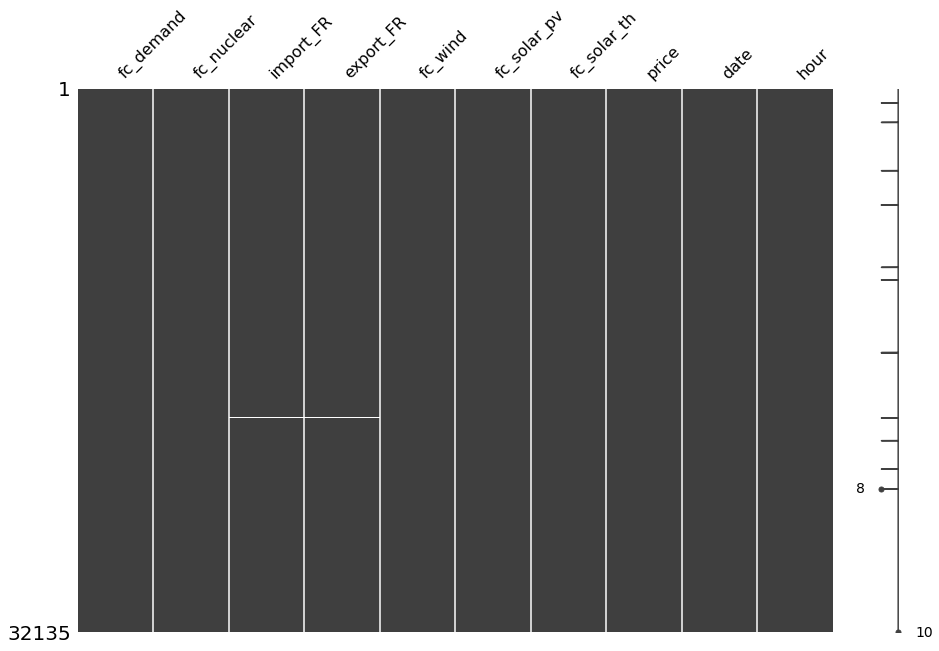

In [16]:
msno.matrix(df, figsize=(15, 10))

In [17]:
missing_df = df.copy()

for var in ["export_FR", "import_FR"]:
    missing_df[f"missing_{var}"] = missing_df[var].isna()

It's important to check whether missing variables are correlated with other variables in our dataset (and with the other missing values).

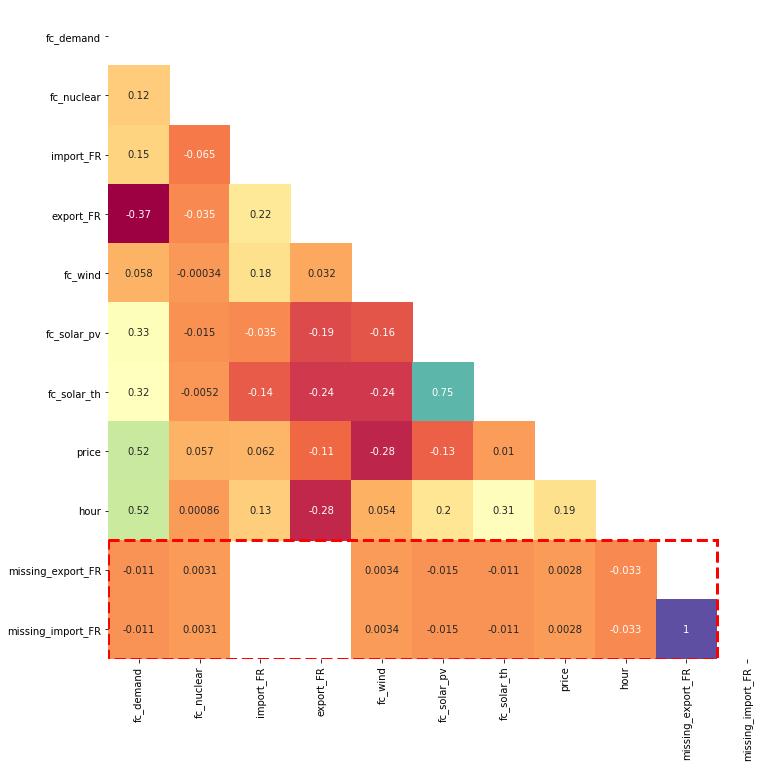

In [18]:
f, ax = plt.subplots(figsize=(12, 12))
corr_df = missing_df.corr()
mask_ut = np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="Spectral", annot=True, cbar=False, ax=ax)
rectangle = patches.Rectangle((0, 9), 10, 2, fill=False, edgecolor="r", linewidth=3, linestyle="--")
ax.add_patch(rectangle)

Thankfully, it seems other variables don't affect the "missingness" of `import_FR` and `export_FR`, although they are perfectly correlated with each other. We will fill these missing values in the feature engineering section by using `KNNImputer`.

### Time Series Visualizations

In [19]:
df.columns

Index(['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind',
       'fc_solar_pv', 'fc_solar_th', 'price', 'date', 'hour'],
      dtype='object')

/Users/inigo/miniconda3/envs/ML/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


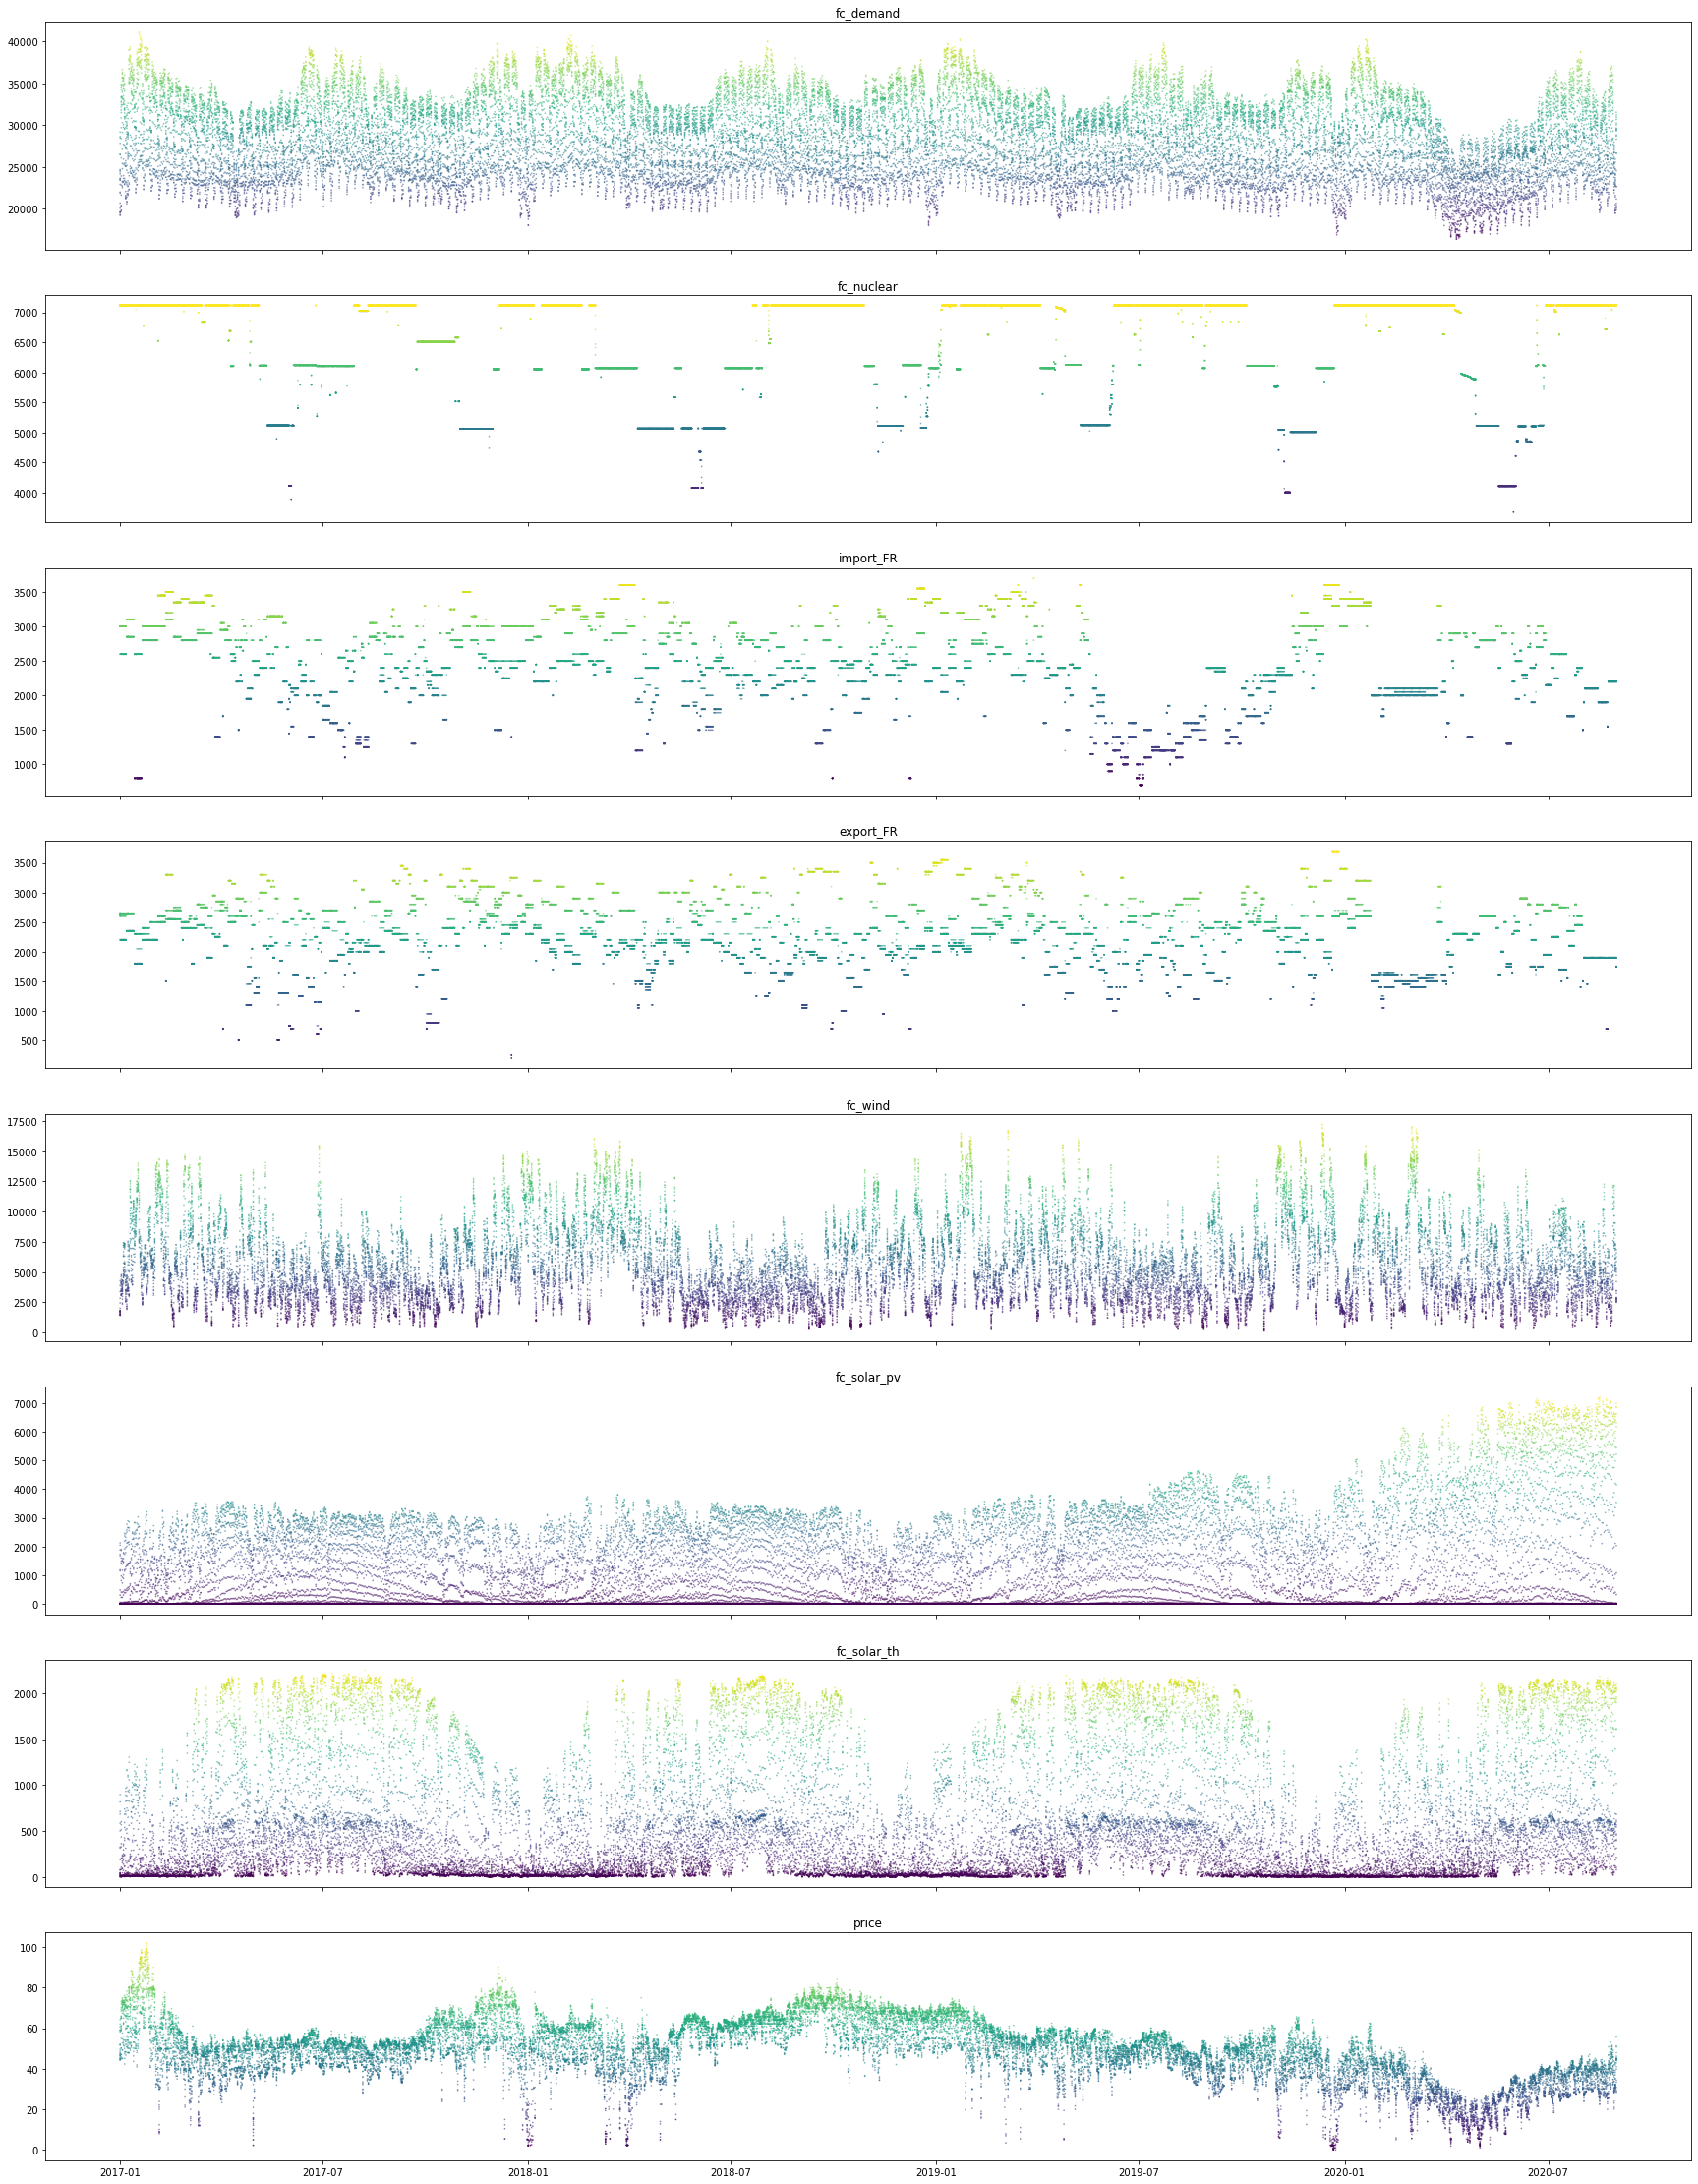

In [20]:
fig, axes = plt.subplots(nrows=len(df.columns) - 2, sharex=True, figsize=(30, 40))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(df["date"], df.iloc[:, i], s=0.5, alpha=0.5, c=df.iloc[:, i])
    ax.set_title(df.columns[i])

plt.show()

Text(0.5, 1.0, 'Solar Production')

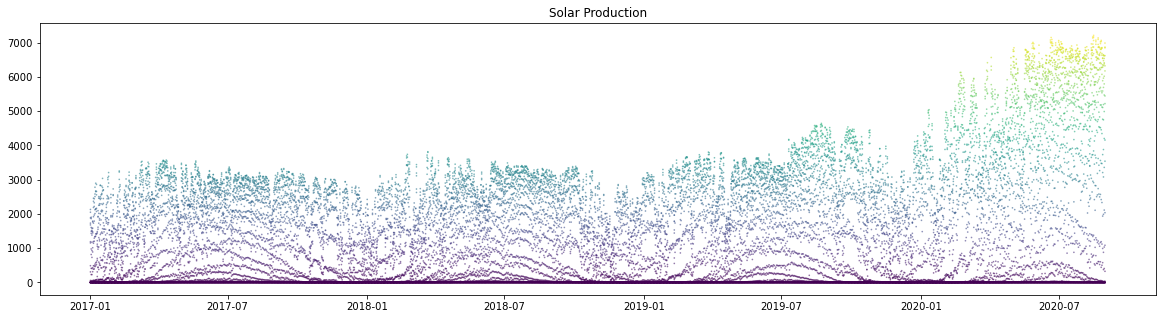

In [318]:
plt.figure(figsize=(20, 5))
plt.scatter(df["date"], df["fc_solar_pv"], s=0.5, alpha=0.5, c=df["fc_solar_pv"])
plt.title("Solar Production")

Text(0.5, 1.0, 'Forecast Demand')

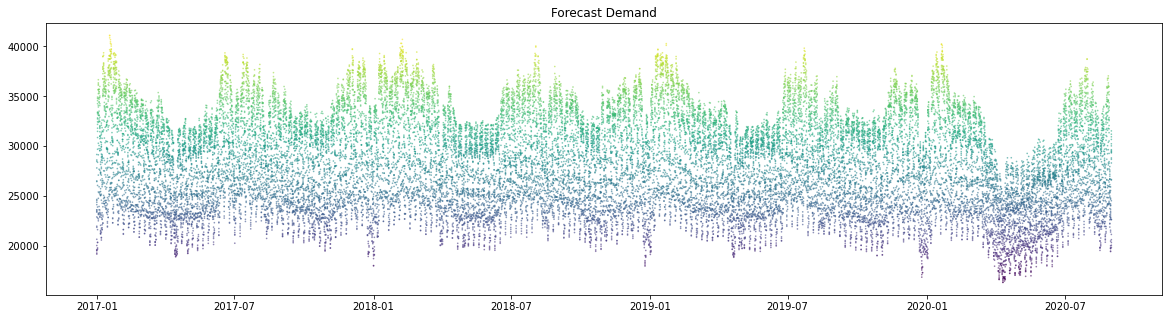

In [319]:
plt.figure(figsize=(20, 5))
plt.scatter(df["date"], df["fc_demand"], s=0.5, alpha=0.5, c=df["fc_demand"])
plt.title("Forecast Demand")

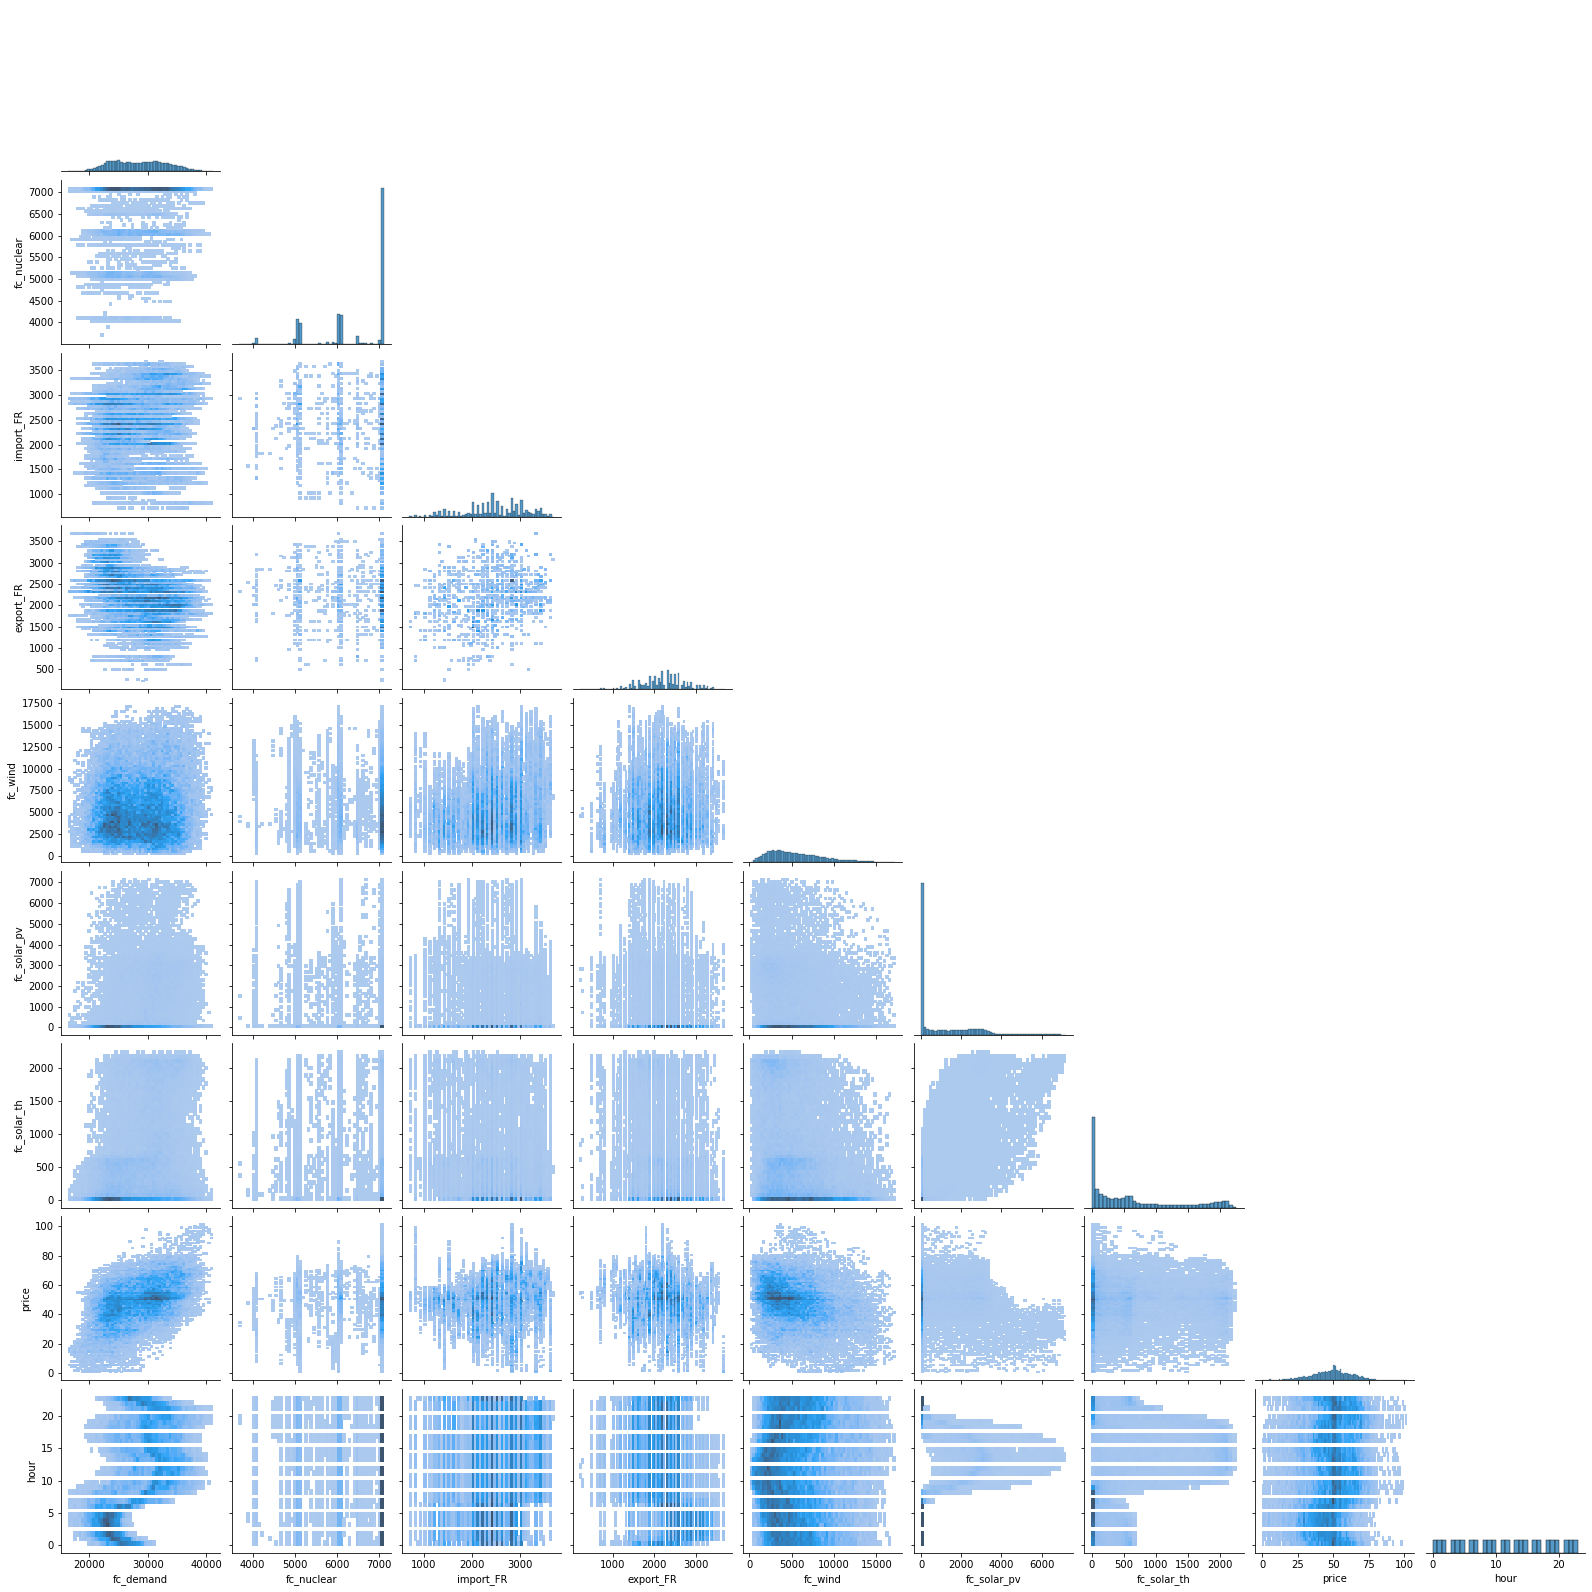

In [21]:
sns.pairplot(df, kind="hist", corner=True)

#### Time-series Summaries

In [22]:
df_viz = df.copy()

In [23]:
df_viz["month"] = df_viz["date"].dt.month
df_viz["dayofweek"] = df_viz["date"].dt.dayofweek

In [287]:
def summarise_time_series(df, column, summary_columns=["hour", "month"]):
    fig, axes = plt.subplots(ncols=len(summary_columns), nrows=1, sharey=True, figsize=(20, 6))
    fig.suptitle(column)
    for i, ax in enumerate(axes.flatten()):
        sns.boxplot(data=df, x=summary_columns[i], y=column, ax=ax)

In [288]:
df_viz.columns

Index(['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind',
       'fc_solar_pv', 'fc_solar_th', 'price', 'date', 'hour', 'month',
       'dayofweek'],
      dtype='object')

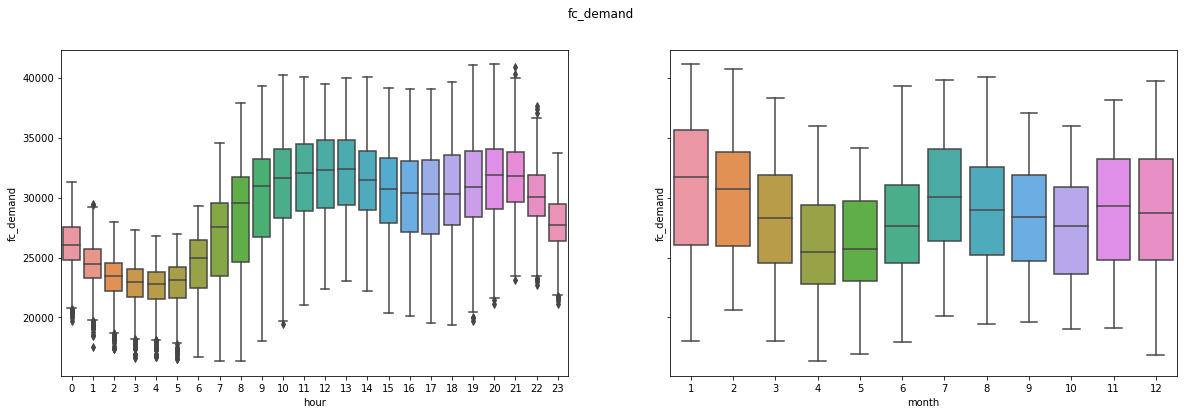

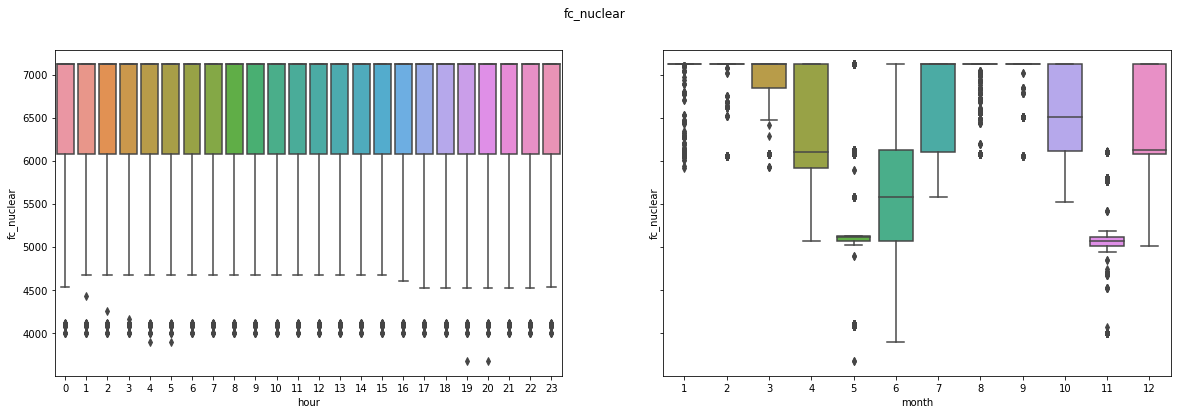

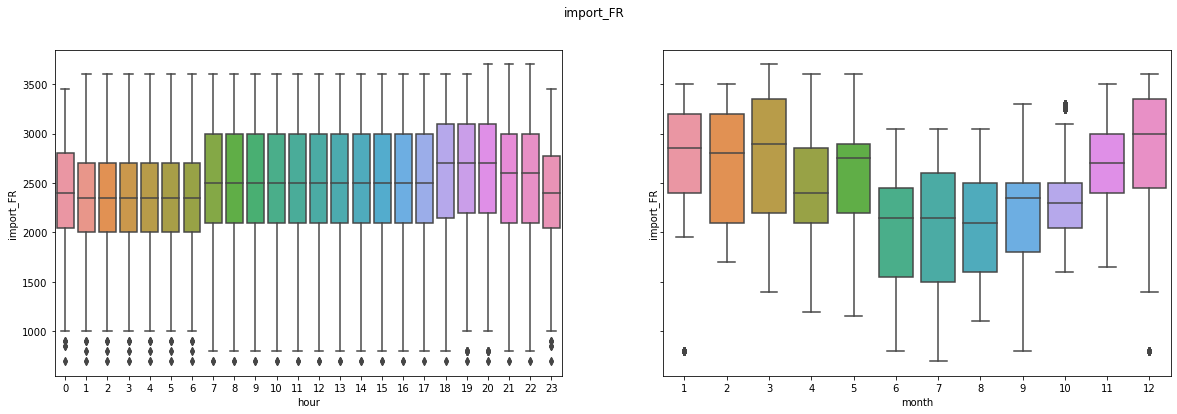

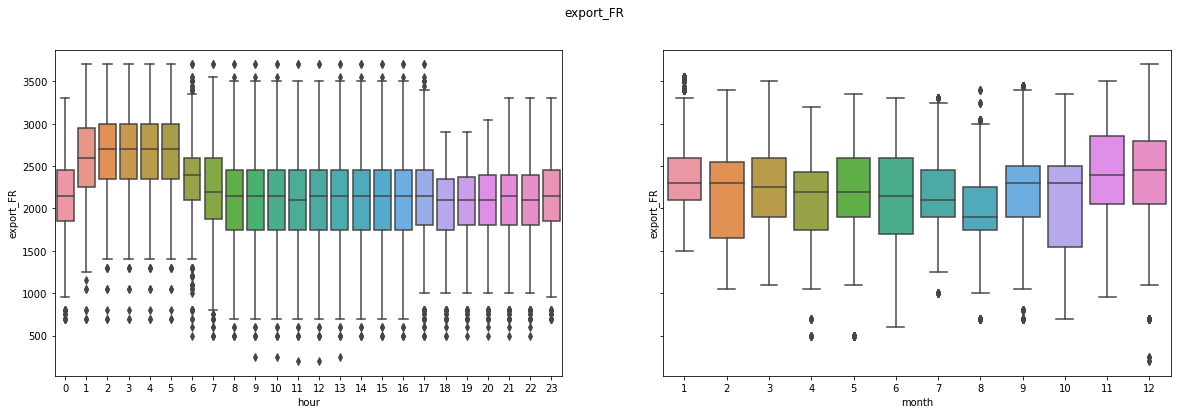

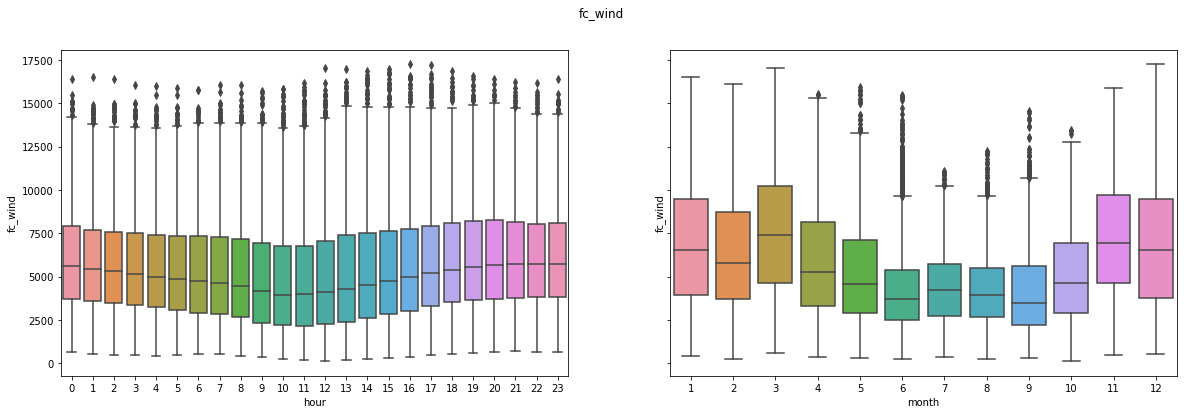

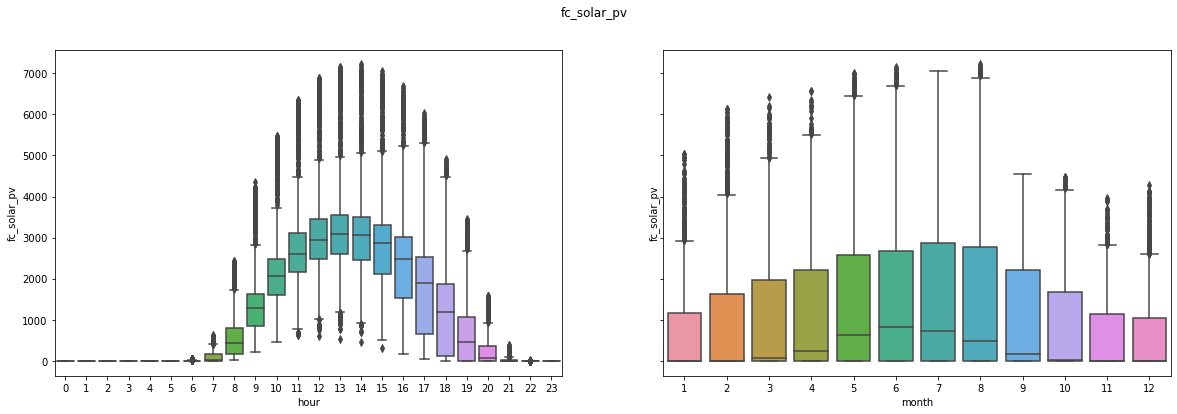

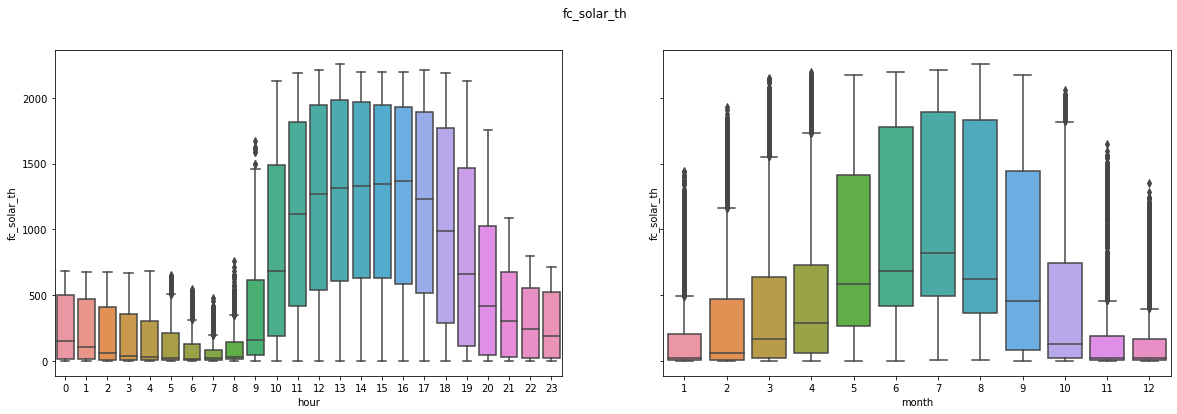

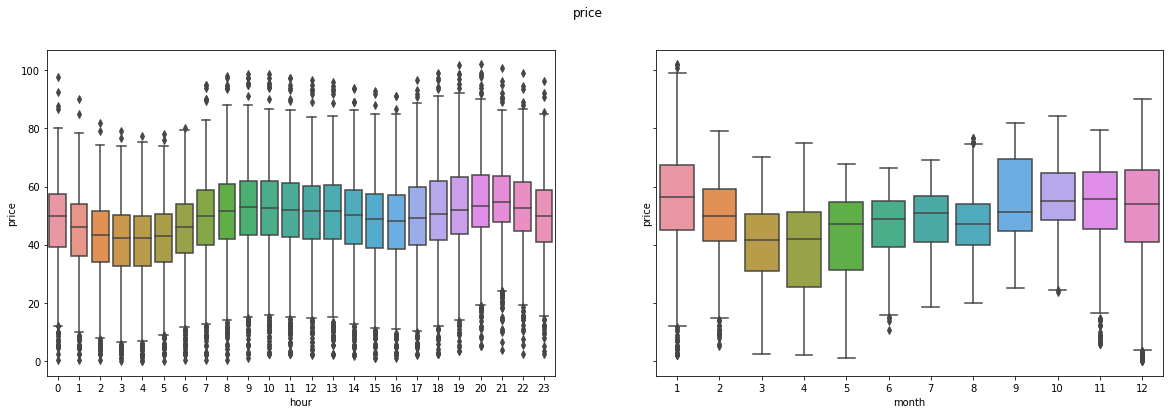

In [289]:
columns_to_viz = ["fc_demand", "fc_nuclear", "import_FR", "export_FR", "fc_wind", "fc_solar_pv", "fc_solar_th", "price"]

for col in columns_to_viz:
    summarise_time_series(df_viz, col)

### Correlations

#### Pearson correlation matrix

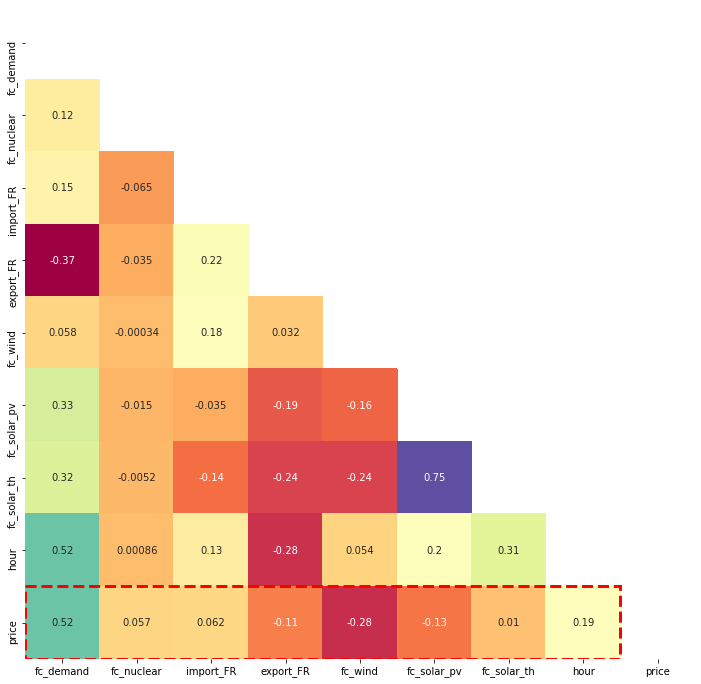

In [27]:
f, ax = plt.subplots(figsize=(12, 12))
df_corr = pd.concat([df.drop("price", axis=1), df[["price"]]], axis=1)
corr_df = df_corr.corr()
mask_ut = np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="Spectral", annot=True, cbar=False, ax=ax)
rectangle = patches.Rectangle((0, 8), 8, 1, fill=False, edgecolor="r", linewidth=3, linestyle="--")
ax.add_patch(rectangle)

#### Mutual Information

In [28]:
X_minfo = X.select_dtypes(include=np.number).dropna(how="any")
y_minfo = y[X_minfo.index]

In [29]:
mutual_info = pd.DataFrame(mutual_info_regression(X_minfo, y_minfo), index=X_minfo.columns, columns=["mutual_info"])

In [30]:
mutual_info.sort_values("mutual_info", ascending=False)

mutual_info
import_FR       0.453731
fc_nuclear      0.443080
export_FR       0.431513
fc_demand       0.195219
fc_solar_pv     0.083632
fc_wind         0.080351
fc_solar_th     0.062979
hour            0.049136

## Dataset splitting

We make our test set size equal to the number rows in our scoring dataset.

In [32]:
test_rows = scoring_df.shape[0]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_rows, shuffle=False
)  # shuffle:False means it conserves first X rows in train and rest in test

In [34]:
X_test.shape

(3673, 9)

## Preprocessing

### Simple Preprocessing

Serves as a baseline.

`SimpleImpute` and drop all non-numeric (only date).

In [35]:
simple_preprocessing = ColumnTransformer(
    [
        ("import_export_imputer", SimpleImputer(), ["import_FR", "export_FR"]),
        ("date_dropper", "drop", ["date"]),
    ],
    remainder="passthrough",
)

### Feature engineering

#### DateEncoder

This `DateEncoder` is a result of our iterative feature engineering process. As we discovered new patterns in the data we added more features.
It works in the same way as `FunctionTransformer`s, so it can be included as a step in a pipeline, and its parameters can be changed so it behaves differently (include some features or not). This allows for clean pipelines, and prevents us from having to make copies of dataframes for every type of preprocessing we want to do.

These are the features it can extract:
* `season`, which can be returned as a column of strings or as a series of encoded columns
* `is_holiday`, whether or not it is a holiday in Spain
* `is_weekend`
* `is_business_day`, the combination of the two previous features
* `sunlight`, hours of sunlight
* `sun`, whether or not the sun is up at any given hour (rounds to the nearest hour)
* `t_from_zenith`, the hours away from the sun's zenith
* `day_period`, the period of the day

In [36]:
class DateEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, date_feature_name="date", hour_feature_name="hour", drop_date_col=True, drop_hour_col=True, ohe_cats=True):
        self.date_feature_name = date_feature_name
        self.hour_feature_name = hour_feature_name
        self.drop_date_col = drop_date_col
        self.drop_hour_col = drop_hour_col
        self.ohe_cats = ohe_cats

    def fit(self, X, y=None):
        return self

    def create_sun_items(self, date_series, city="Madrid", region="Spain", timezone="Europe/Madrid", latitude=40.4168, longitude=3.7038):
        city = LocationInfo(city, region, timezone, latitude, longitude)
        s = date_series.apply(lambda x: sun.sun(city.observer, date=x, tzinfo=city.timezone))
        self.sun_items = s

    def transform(self, X):
        X_ = X.copy()

        month = X_[self.date_feature_name].dt.month
        X_["season"] = np.where(
            np.logical_or(month < 3, month == 12),
            "winter",
            np.where(np.logical_and(month >= 3, month < 6), "spring", np.where(np.logical_and(month >= 6, month < 9), "summer", "autumn")),
        )

        

        start_date = X_[self.date_feature_name].min()
        end_date = X_[self.date_feature_name].max()
        date_range = pd.bdate_range(start_date, end_date, freq=spain_calendar)
        holiday = X_[self.date_feature_name].isin(date_range)
        holiday = ~holiday
        X_["is_holiday"] = holiday.astype(int)

        # TODO: morning vs midday vs evening

        hour_cats_enc = np.where(
            np.logical_and(
                X_[self.hour_feature_name] >= 0,
                X_[self.hour_feature_name] < 6,
            ),
            "night",
            np.where(
                np.logical_and(X_[self.hour_feature_name] >= 6, X_[self.hour_feature_name] < 11),
                "morning",
                np.where(
                    np.logical_and(X_[self.hour_feature_name] >= 11, X_[self.hour_feature_name] < 18),
                    "day",
                    np.where(
                        np.logical_and(X_[self.hour_feature_name] >= 18, X_[self.hour_feature_name] < 22),
                        "evening",
                        np.where(np.logical_and(X_[self.hour_feature_name] >= 22, X_[self.hour_feature_name] < 24), "night", np.nan),
                    ),
                ),
            ),
        )

        X_["day_period"] = hour_cats_enc

        self.create_sun_items(X_[self.date_feature_name])
        X_["sun_item"] = self.sun_items
        X_["sunlight_s"] = X_.apply(lambda row: (row["sun_item"]["sunset"] - row["sun_item"]["dawn"]).seconds, axis=1)
        X_["sun"] = X_.apply(lambda row: row["sun_item"]["sunrise"].hour < row[self.hour_feature_name] < row["sun_item"]["sunset"].hour, axis=1).astype(int)
        X_["t_from_zenith"] = X_.apply(lambda row: np.abs(row["sun_item"]["noon"].hour - row[self.hour_feature_name]), axis=1)
        X_ = X_.drop("sun_item", axis=1)

        X_["is_weekend"] = (X_[self.date_feature_name].dt.dayofweek >= 5).astype(int)

        business_day = ~np.logical_or(X_["is_holiday"], X_["is_weekend"])
        X_["is_business_day"] = business_day.astype(int)

        # X_["time_of_day"]

        if self.ohe_cats:
            ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
            seasons_ohe = ohe.fit_transform(X_[["season"]])
            season_cols = ohe.get_feature_names(["season"])
            seasons_ohe = pd.DataFrame(seasons_ohe, columns=season_cols)
            
            dayperiod_ohe = ohe.fit_transform(X_[["day_period"]])
            dayperiod_cols = ohe.get_feature_names(["day_period"])
            dayperiod_ohe = pd.DataFrame(dayperiod_ohe, columns=dayperiod_cols)
            
            
            index = X_.index
            seasons_ohe.index = X_.index
            # X_ = pd.concat([X_, seasons_ohe], sort=False, axis=1, ignore_index=True, join_axes=[X_.index])
            X_ = pd.concat([X_, seasons_ohe, dayperiod_ohe], axis=1)
            # X_.index = index
            X_ = X_.drop("season", axis=1)
            
            
        if self.drop_date_col:
            X_ = X_.drop(self.date_feature_name, axis=1)
        if self.drop_hour_col:
            X_ = X_.drop(self.hour_feature_name, axis=1)

        return X_

    # TODO: def get_feature_names():

#### EnergyEncoder

This `EnergyEncoder` extracts ratios and differences between `fc_demand` and all the sources of production in our dataset.

In [179]:
class EnergyEncoder(TransformerMixin, BaseEstimator):
    """A template for a custom transformer."""

    def __init__(self, calculate_ratios=True, calculate_diffs=True, impute_imp_exp=True):
        self.calculate_ratios = calculate_ratios
        self.calculate_diffs = calculate_diffs
        self.impute_imp_exp = impute_imp_exp

    #     def generate_thermal_gap(self, df):
    #         self.thermal_gap = df["fc_demand"] - df["fc_nuclear"] - df["fc_wind"] - df["fc_solar_pv"] - df["fc_solar_th"]

    def generate_ratios(self, df, numerators, denominators=["fc_demand"]):
        ratios = {}
        for denominator in denominators:
            for numerator in numerators:
                ratios[f"{numerator}/{denominator}"] = df[numerator] / df[denominator]
            ratios[f"total/{denominator}"] = df[numerator] / df[numerators].sum(axis=1)
        self.ratios = ratios

    def generate_diffs(self, df, left_amounts, right_amounts):
        diffs = {}
        for left_amount in left_amounts:
            for right_amount in right_amounts:
                diffs[f"dif_{left_amount}_{right_amount}"] = df[left_amount] - df[right_amount]
            diffs[f"dif_{left_amount}_total"] = df[left_amount] - df[right_amounts].sum(axis=1)
        self.diffs = diffs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()

        if self.impute_imp_exp:
            imp_X_ = X_.select_dtypes(include=np.number)
            cols = imp_X_.columns
            knnimp = KNNImputer()
            imp_X_ = knnimp.fit_transform(imp_X_)
            imp_df = pd.DataFrame(imp_X_, columns=cols, index=X_.index)[["import_FR", "export_FR"]]
            X_["import_FR"] = imp_df["import_FR"]
            X_["export_FR"] = imp_df["export_FR"]

        if self.calculate_ratios:
            self.generate_ratios(X, ["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th"], ["fc_demand"])
            X_ = pd.concat([X_, pd.DataFrame(self.ratios)], sort=False, axis=1)

        #         if self.calculate_thermal_gap:
        #             self.generate_thermal_gap(X)
        #             X_["thermal_gap"] = self.thermal_gap
        if self.calculate_diffs:
            self.generate_diffs(X_, ["fc_demand"], ["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th"])
            X_ = pd.concat([X_, pd.DataFrame(self.diffs)], sort=False, axis=1)
        return X_

    # TODO: def get_feature_names():

In [180]:
EnergyEncoder().fit_transform(X_train)

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0        24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1        23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2        21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3        20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4        19599.0      7117.2     3000.0     2650.0   1746.0          0.0   
...          ...         ...        ...        ...      ...          ...   
28457    24870.0      7117.2     2050.0     1600.0   8761.0       1387.2   
28458    26002.0      7117.2     2050.0     1600.0   8598.0        571.0   
28459    27981.0      7117.2     2050.0     1600.0   8236.0         65.7   
28460    29460.0      7117.2     2050.0     1600.0   8369.0          0.0   
28461    26892.0      7117.2     2050.0     1600.0   8278.0          0.0   

       fc_solar_th       date  hour  fc_nuclear/fc_demand  fc_wind/fc_demand  \
0              5.1 2017-01-01     0              0.291689           0.070984   
1              0.6 2017-01-01     1              0.301372           0.077320   
2              4.6 2017-01-01     2              0.325090           0.083269   
3              9.7 2017-01-01     3              0.343942           0.085874   
4             24.1 2017-01-01     4              0.363141           0.089086   
...            ...        ...   ...                   ...                ...   
28457         72.9 2020-03-31    18              0.286176           0.352272   
28458         63.1 2020-03-31    19              0.273717           0.330667   
28459         85.7 2020-03-31    20              0.254358           0.294343   
28460         14.4 2020-03-31    21              0.241589           0.284080   
28461          7.9 2020-03-31    22              0.264659           0.307824   

       fc_solar_pv/fc_demand  fc_solar_th/fc_demand  total/fc_demand  \
0                   0.000000               0.000209         0.000576   
1                   0.000000               0.000025         0.000067   
2                   0.000000               0.000210         0.000514   
3                   0.000000               0.000469         0.001089   
4                   0.000000               0.001230         0.002712   
...                      ...                    ...              ...   
28457               0.055778               0.002931         0.004205   
28458               0.021960               0.002427         0.003859   
28459               0.002348               0.003063         0.005527   
28460               0.000000               0.000489         0.000929   
28461               0.000000               0.000294         0.000513   

       dif_fc_demand_fc_nuclear  dif_fc_demand_fc_wind  \
0                       17282.8                22668.0   
1                       16498.8                21790.0   
2                       14775.8                20070.0   
3                       13575.8                18916.0   
4                       12481.8                17853.0   
...                         ...                    ...   
28457                   17752.8                16109.0   
28458                   18884.8                17404.0   
28459                   20863.8                19745.0   
28460                   22342.8                21091.0   
28461                   19774.8                18614.0   

       dif_fc_demand_fc_solar_pv  dif_fc_demand_fc_solar_th  \
0                        24400.0                    24394.9   
1                        23616.0                    23615.4   
2                        21893.0                    21888.4   
3                        20693.0                    20683.3   
4                        19599.0                    19574.9   
...                          ...                        ...   
28457                    23482.8                    24797.1   
28458                    25431.0                    25938.9   
2845

In [181]:
custom_preprocessing = make_pipeline(EnergyEncoder(), DateEncoder(ohe_cats=False))

In [182]:
transformed_df = custom_preprocessing.fit_transform(X_train, y_train)

In [183]:
all_features_df = pd.concat([transformed_df, y_train], axis=1)

In [184]:
all_features_df.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  fc_nuclear/fc_demand  fc_wind/fc_demand  \
0          5.1              0.291689           0.070984   
1          0.6              0.301372           0.077320   
2          4.6              0.325090           0.083269   
3          9.7              0.343942           0.085874   
4         24.1              0.363141           0.089086   

   fc_solar_pv/fc_demand  ...  dif_fc_demand_total  season  is_holiday  \
0                    0.0  ...              15545.7  winter           1   
1                    0.0  ...              14672.2  winter           1   
2                    0.0  ...              12948.2  winter           1   
3                    0.0  ...              11789.1  winter           1   
4                    0.0  ...              10711.7  winter           1   

   day_period  sunlight_s  sun  t_from_zenith is_weekend  is_business_day  \
0       night       35511    0             12          1                0   
1       night       35511    0             11          1                0   
2       night       35511    0             10          1                0   
3       night       35511    0              9          1                0   
4       night       35511    0              8          1                0   

   price  
0  58.82  
1  58.23  
2  51.95  
3  47.27  
4  45.49  

[5 rows x 26 columns]

### Visualizing New Variables

In [185]:
display_preprocessing = make_pipeline(EnergyEncoder(), DateEncoder(ohe_cats=True, drop_date_col=False, drop_hour_col=False))

In [186]:
display_preprocessed_df = display_preprocessing.fit_transform(X_train)

In [296]:
all_features_display_df =  pd.concat([display_preprocessed_df, y_train], axis=1)

In [297]:
all_features_display_df["month"] = all_features_display_df["date"].dt.month
all_features_display_df["dayofweek"] = all_features_display_df["date"].dt.dayofweek

In [298]:
all_features_display_df.columns

Index(['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind',
       'fc_solar_pv', 'fc_solar_th', 'date', 'hour', 'fc_nuclear/fc_demand',
       'fc_wind/fc_demand', 'fc_solar_pv/fc_demand', 'fc_solar_th/fc_demand',
       'total/fc_demand', 'dif_fc_demand_fc_nuclear', 'dif_fc_demand_fc_wind',
       'dif_fc_demand_fc_solar_pv', 'dif_fc_demand_fc_solar_th',
       'dif_fc_demand_total', 'is_holiday', 'day_period', 'sunlight_s', 'sun',
       't_from_zenith', 'is_weekend', 'is_business_day', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter', 'day_period_day',
       'day_period_evening', 'day_period_morning', 'day_period_night', 'price',
       'month', 'dayofweek'],
      dtype='object')

<Figure size 1080x720 with 0 Axes>

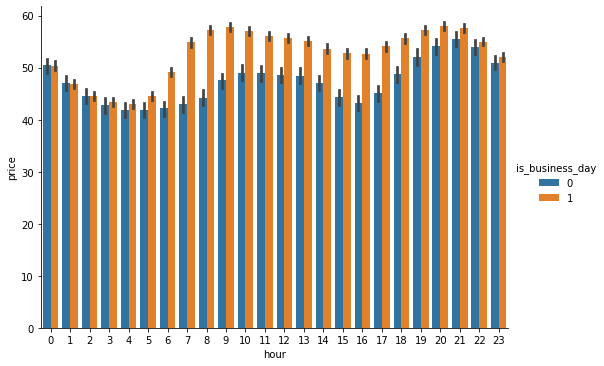

In [190]:
plt.figure(figsize=(15, 10))
sns.catplot(data=all_features_display_df, kind="bar", x="hour", y="price", hue="is_business_day",height=5, aspect=11.7/8.27)

<Figure size 1080x720 with 0 Axes>

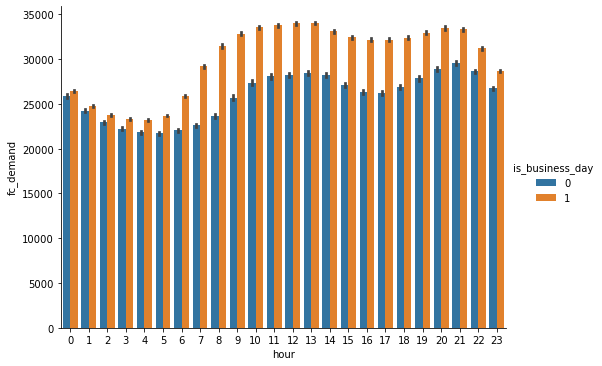

In [191]:

plt.figure(figsize=(15, 10))
sns.catplot(data=all_features_display_df, kind="bar", x="hour", y="fc_demand", hue="is_business_day",height=5, aspect=11.7/8.27)

<AxesSubplot:xlabel='dif_fc_demand_total', ylabel='price'>

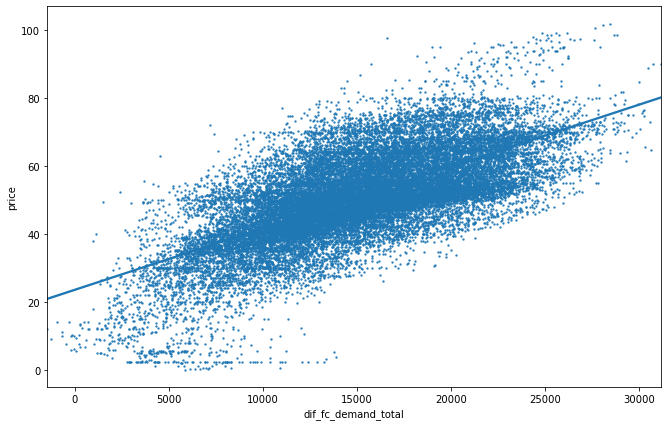

In [192]:
plt.figure(figsize=(11, 7))
sns.regplot(data=all_features_display_df, x="dif_fc_demand_total", y="price", scatter_kws={'s':2})

<AxesSubplot:xlabel='fc_demand', ylabel='price'>

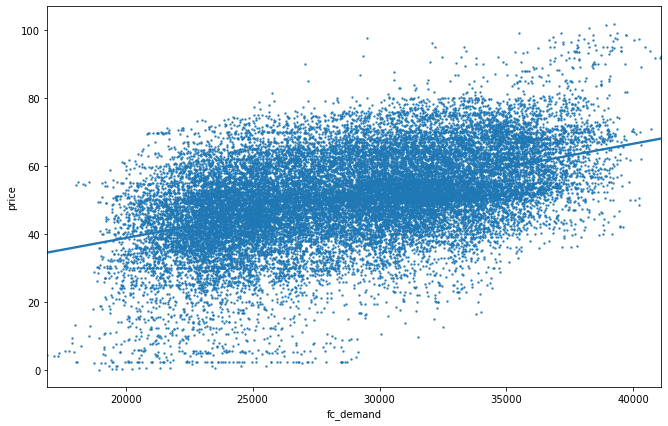

In [193]:
plt.figure(figsize=(11, 7))
sns.regplot(data=all_features_display_df, x="fc_demand", y="price", scatter_kws={'s':2})

<AxesSubplot:xlabel='month', ylabel='dif_fc_demand_total'>

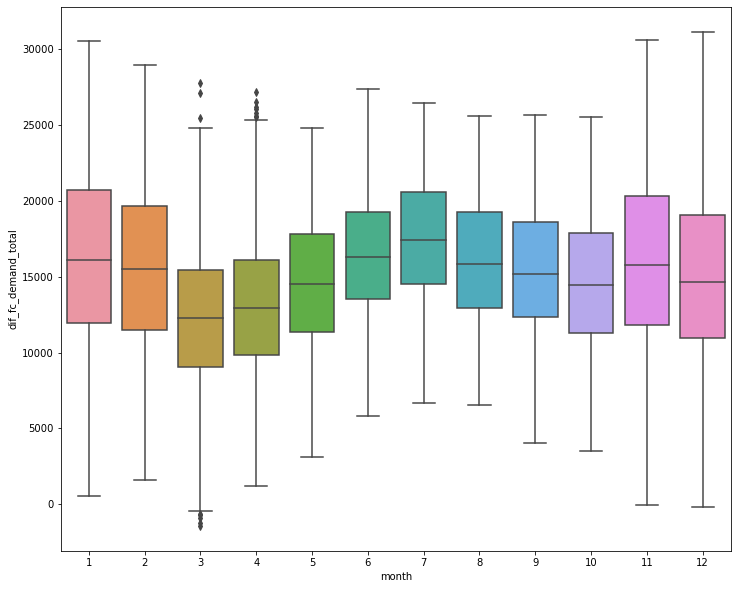

In [304]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=all_features_display_df, x="month", y="dif_fc_demand_total")

<AxesSubplot:xlabel='hour', ylabel='dif_fc_demand_total'>

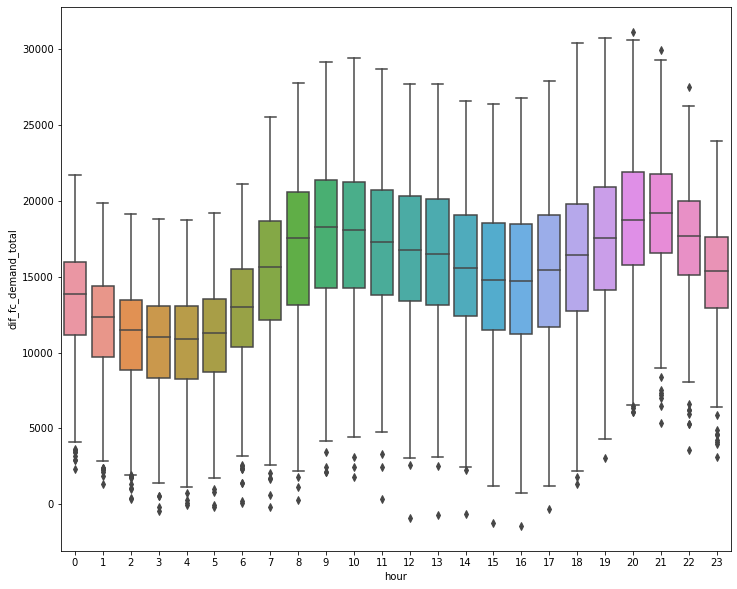

In [305]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=all_features_display_df, x="hour", y="dif_fc_demand_total")

### Feature Selection

In [198]:
all_features_display_df = all_features_display_df.drop(["month", "dayofweek", "hour"], axis=1)
all_features_corr_df = all_features_display_df.corr()

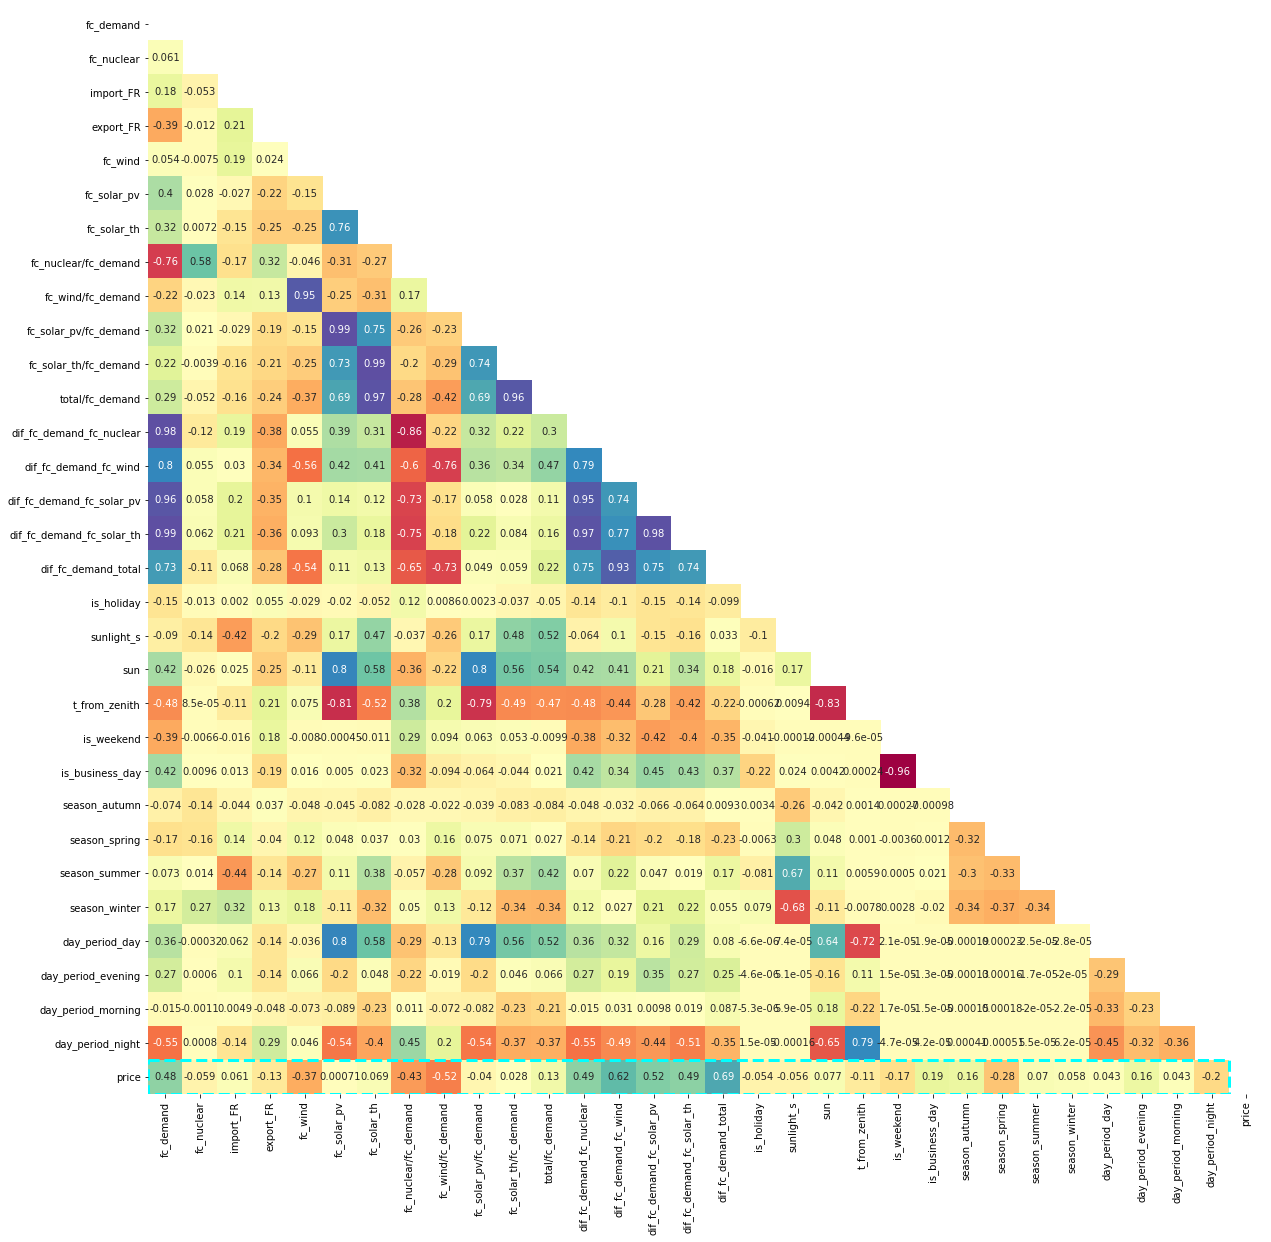

In [199]:
f, ax = plt.subplots(figsize=(20, 20))
mask_ut = np.triu(np.ones(all_features_corr_df.shape)).astype(np.bool)

ax = sns.heatmap(all_features_corr_df, cmap="Spectral", annot=True, cbar=False, mask=mask_ut)
rectangle = patches.Rectangle((0, 31), 31, 1, fill=False, edgecolor="cyan", linewidth=3, linestyle="--")
ax.add_patch(rectangle)

#### Mutual Information

In [200]:
X_minfo = display_preprocessed_df.select_dtypes(include=np.number).dropna(how="any")
y_minfo = y[X_minfo.index]

In [201]:
mutual_info = pd.DataFrame(mutual_info_regression(X_minfo, y_minfo), index=X_minfo.columns, columns=["mutual_info"])

In [204]:
mutual_info.sort_values("mutual_info", ascending=False).head(15)

mutual_info
sunlight_s                    0.546832
import_FR                     0.455487
export_FR                     0.430085
dif_fc_demand_total           0.387599
fc_nuclear                    0.346977
dif_fc_demand_fc_wind         0.308143
dif_fc_demand_fc_solar_pv     0.202925
fc_wind/fc_demand             0.199281
dif_fc_demand_fc_solar_th     0.173173
dif_fc_demand_fc_nuclear      0.168788
fc_demand                     0.167784
fc_nuclear/fc_demand          0.156815
fc_wind                       0.122667
season_spring                 0.117398
season_summer                 0.102191

## Model Testing

### Simple Linear Regression

In [205]:
simple_reg = Pipeline(
    [
        ("preprocessing", simple_preprocessing),
        ("regression", LinearRegression()),
    ]
)

In [206]:
simple_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('import_export_imputer',
                                                  SimpleImputer(),
                                                  ['import_FR', 'export_FR']),
                                                 ('date_dropper', 'drop',
                                                  ['date'])])),
                ('regression', LinearRegression())])

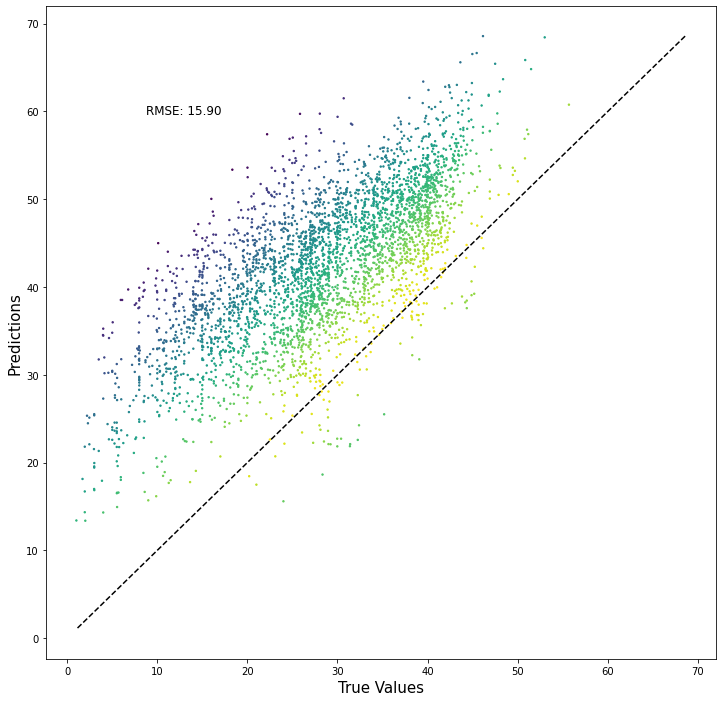

In [207]:
evaluate_model(simple_reg, X_test, y_test)

In [208]:
split_date = X_test["date"].iloc[0]

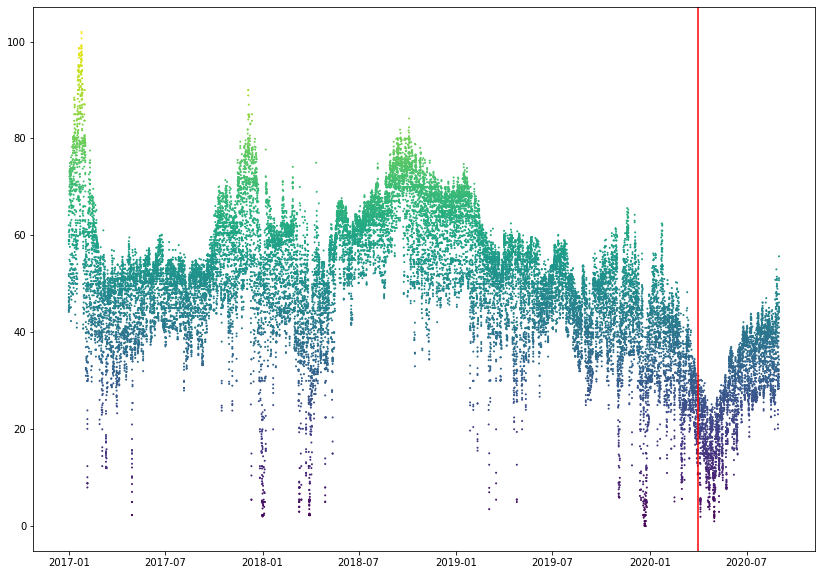

In [210]:
plt.figure(figsize=(14, 10))
plt.scatter(X["date"], y, c=y, cmap="viridis", s=1)
plt.axvline(split_date, c="r")

### Feature Engineered Linear Regression

EnergyEncoder() + DateEncoder()

In [211]:
custom_preprocessing

Pipeline(steps=[('energyencoder', EnergyEncoder()),
                ('dateencoder', DateEncoder(ohe_cats=False))])

In [212]:
one_hot_season = ColumnTransformer([("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"), ["season", "day_period"])], remainder="passthrough")

In [213]:
preprocessing = make_pipeline(custom_preprocessing, one_hot_season)  # , StandardScaler(), PCA())

In [214]:
feateng_lr_reg = make_pipeline(preprocessing, LinearRegression())

In [215]:
feateng_lr_reg.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('linearregression', LinearRegression())])

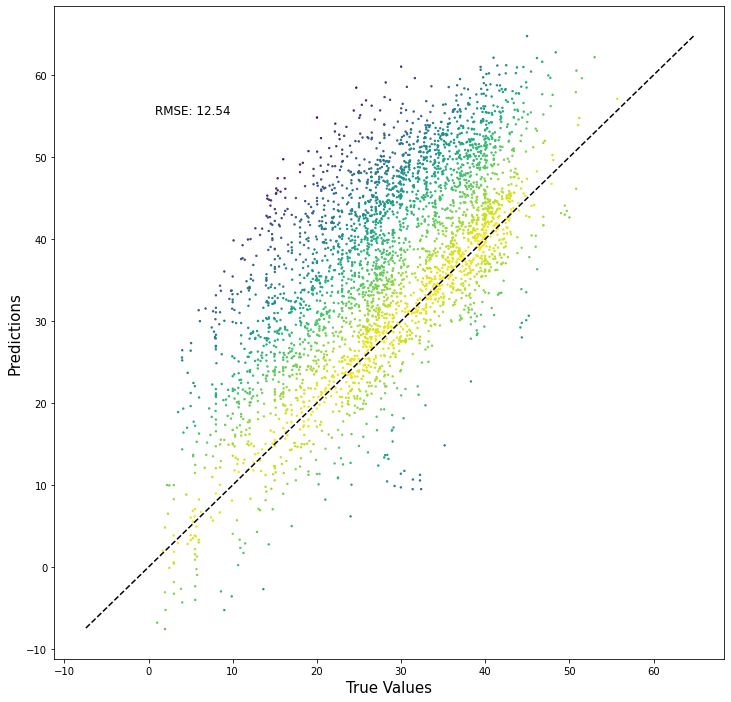

In [216]:
evaluate_model(feateng_lr_reg, X_test, y_test)

### Feature Engineered Random Forest

In [217]:
feateng_rf_reg = make_pipeline(preprocessing, RandomForestRegressor())

In [218]:
feateng_rf_reg.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('randomforestregressor', RandomForestRegressor())])

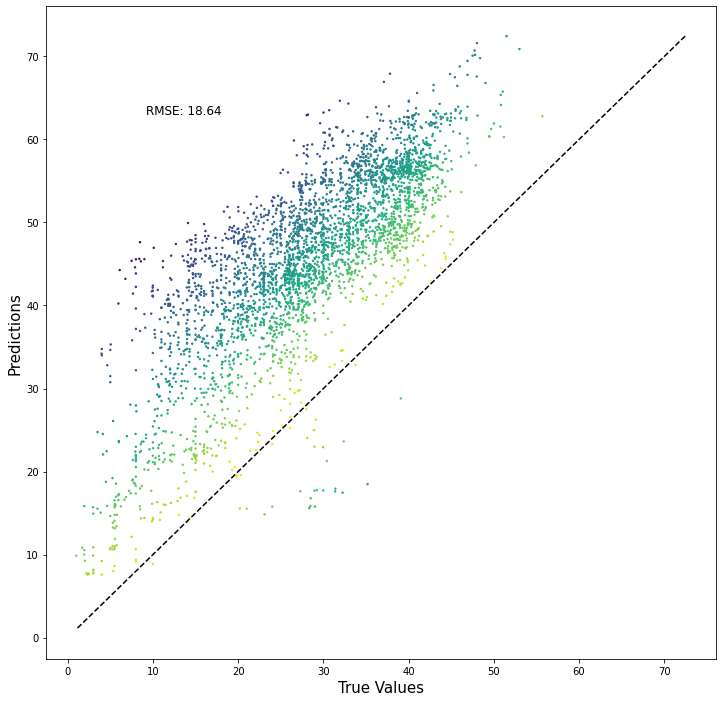

In [219]:
evaluate_model(feateng_rf_reg, X_test, y_test)

### Feature Engineered XGBoost

In [220]:
import sklearn

In [221]:
feateng_xgb_reg = make_pipeline(preprocessing, XGBRegressor())

In [222]:
feateng_xgb_reg.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

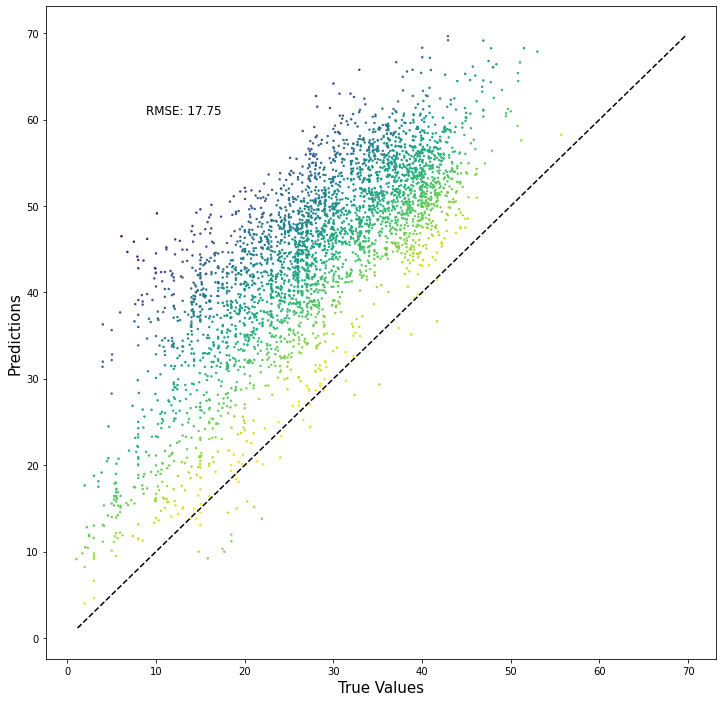

In [223]:
evaluate_model(feateng_xgb_reg, X_test, y_test)

#### Early Stopping XGB

In [224]:
X_xg_train, X_xg_val, y_xg_train, y_xg_val = train_test_split(
    X_train, y_train, test_size=test_rows, shuffle=False
)  # shuffle:False means it conserves first X rows in train and rest in test

In [225]:
X_xg_train_t = preprocessing.fit_transform(X_xg_train)
X_xg_val_t = preprocessing.transform(X_xg_val)

Keep a test set to implement early_stopping

In [226]:
xgb_eval_set = [(X_xg_train_t, y_xg_train), (X_xg_val_t, y_xg_val)]

In [227]:
xgb_earlystopping_reg = sklearn.base.clone(feateng_xgb_reg)

In [228]:
xgb_earlystopping_reg.set_params(**{"xgbregressor__n_estimators": 10000, "xgbregressor__learning_rate": 0.01})

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=10000, n_jobs=8, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [229]:
xgb_earlystopping_reg.fit(X_xg_train, y_xg_train, xgbregressor__eval_set=xgb_eval_set, xgbregressor__early_stopping_rounds=200)

[0]	validation_0-rmse:53.58493	validation_1-rmse:37.02418
[1]	validation_0-rmse:53.05819	validation_1-rmse:36.49500
[2]	validation_0-rmse:52.53677	validation_1-rmse:35.97220
[3]	validation_0-rmse:52.02061	validation_1-rmse:35.45218
[4]	validation_0-rmse:51.50970	validation_1-rmse:34.93990
[5]	validation_0-rmse:51.00384	validation_1-rmse:34.43284
[6]	validation_0-rmse:50.50326	validation_1-rmse:33.93115
[7]	validation_0-rmse:50.00778	validation_1-rmse:33.43489
[8]	validation_0-rmse:49.51714	validation_1-rmse:32.94424
[9]	validation_0-rmse:49.03152	validation_1-rmse:32.45581
[10]	validation_0-rmse:48.55079	validation_1-rmse:31.97352
[11]	validation_0-rmse:48.07488	validation_1-rmse:31.49640
[12]	validation_0-rmse:47.60382	validation_1-rmse:31.02681
[13]	validation_0-rmse:47.13761	validation_1-rmse:30.56253
[14]	validation_0-rmse:46.67621	validation_1-rmse:30.10234
[15]	validation_0-rmse:46.21917	validation_1-rmse:29.64544
[16]	validation_0-rmse:45.76708	validation_1-rmse:29.19218
[17]	va

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=10000, n_jobs=8, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

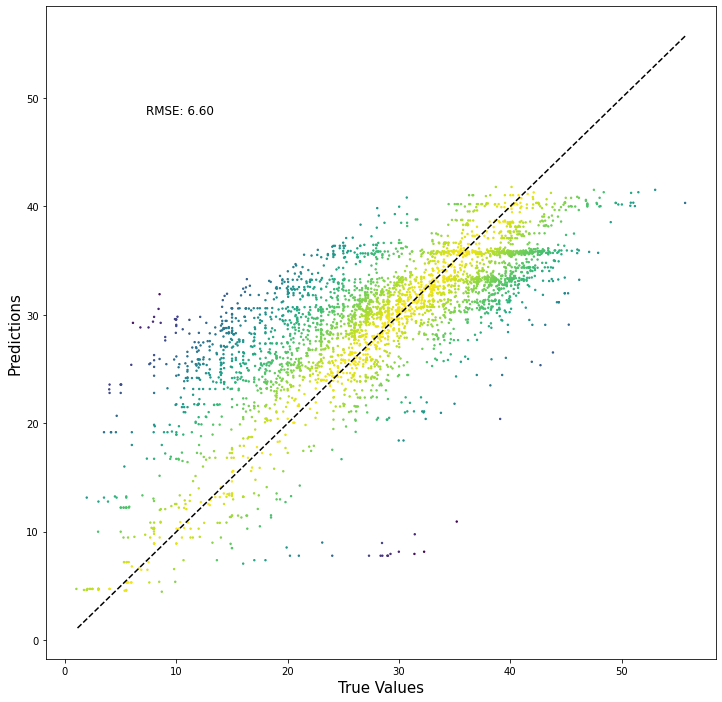

In [230]:
evaluate_model(xgb_earlystopping_reg, X_test, y_test)

In [231]:
xgb_earlystopping_reg.named_steps["xgbregressor"].best_ntree_limit

108

# Parameter Tuning

## Cross-Validation

In [232]:
display(Markdown(f"Each fold should be about $\\frac{{1}}{{{X_train.shape[0]/test_rows:.3f}}}$ of the training set."))

Each fold should be about $\frac{1}{7.749}$ of the training set.

 Rounded that would be $\frac{1}{8}$, but we will keep it at  $\frac{1}{7}$ to avoid slowing down the cross validation too much.

In [233]:
cv = TimeSeriesSplit(7)

In [234]:
scoring = "neg_root_mean_squared_error"

### Validation curves

In [235]:
def plot_validation_curve(score_tuple, param_range, param_name="Parameter", figsize=(12, 8)):
    train_score, val_score = score_tuple
    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    test_scores_mean = np.mean(val_score, axis=1)
    test_scores_std = np.std(val_score, axis=1)

    lw = 2
    plt.figure(figsize=figsize)
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(
        param_range, train_scores_mean - 1.96 * train_scores_std, train_scores_mean + 1.96 * train_scores_std, alpha=0.2, color="darkorange", lw=lw
    )
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.show()

#### Decision Tree

#####  leaf search

#### XGBoost

In [236]:
xgb_pretuned_params = {"xgbregressor__n_estimators":112,
"xgbregressor__learning_rate":0.01}

In [237]:
xgb_n_estimators = "xgbregressor__n_estimators"
max_n_estimators_test1 = np.arange(1, 502, 50)

In [238]:
xgb_vc_reg = make_pipeline(preprocessing, XGBRegressor())
xgb_vc_reg.set_params(**xgb_pretuned_params)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=112,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [239]:
xgb_n_estimators_test1 = validation_curve(
    xgb_vc_reg, X, y, param_name=xgb_n_estimators, param_range=max_n_estimators_test1, scoring=scoring, cv=cv, verbose=3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .......................xgbregressor__n_estimators=1; total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END ......................xgbregressor__n_estimators=51; total time=   2.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] END .....................xgbregressor__n_estimators=101; total time=   2.1s
[CV] END .....................xgbregressor__n_estimators=151; total time=   2.4s
[CV] END .....................xgbregressor__n_estimators=201; total time=   2.9s
[CV] END .....................xgbregressor__n_estimators=251; total time=   3.0s
[CV] END .....................xgbregressor__n_estimators=301; total time=   3.5s
[CV] END .....................xgbregressor__n_estimators=351; total time=   3.8s
[CV] END .....................xgbregressor__n_estimators=401; total time=   4.0s
[CV] END .....................xgbregressor__n_estimators=451; total time=   4.5s
[CV] END .....................xgbregressor__n_estimators=501; total time=   4.5s
[CV] END .......................xgbregressor__n_estimators=1; total time=   2.5s
[CV] END ......................xgbregressor__n_estimators=51; total time=   2.9s
[CV] END .....................xgbregressor__n_estimators=101; total time=   3.5s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed: 15.1min finished


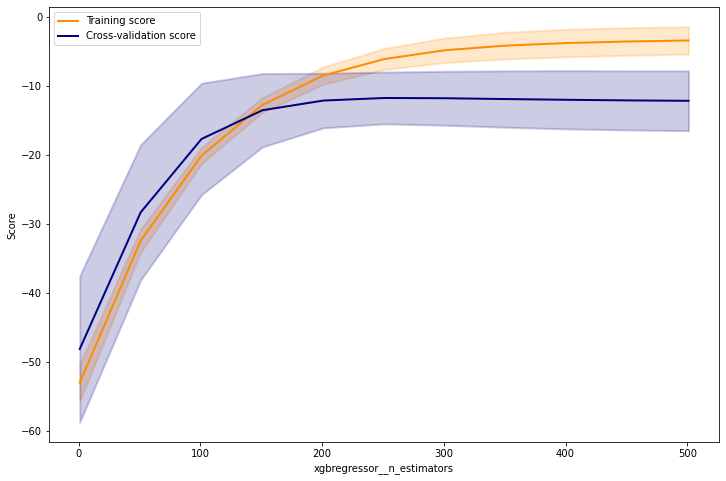

In [240]:
plot_validation_curve(xgb_n_estimators_test1, max_n_estimators_test1, xgb_n_estimators)

In [241]:
xgb_max_depth_param = "xgbregressor__max_depth"
max_depth_range_test1 = np.arange(1, 10, 2)

In [242]:
xgb_vc_reg = make_pipeline(preprocessing, XGBRegressor())
xgb_vc_reg.set_params(**xgb_pretuned_params)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=112,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [243]:
xgb_vc_reg.set_params(**{"xgbregressor__n_estimators":150})

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=150,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [244]:
xgb_max_depth_test1 = validation_curve(
    xgb_vc_reg, X, y, param_name=xgb_max_depth_param, param_range=max_depth_range_test1, scoring=scoring, cv=cv, verbose=3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..........................xgbregressor__max_depth=1; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ..........................xgbregressor__max_depth=3; total time=   2.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] END ..........................xgbregressor__max_depth=5; total time=   2.6s
[CV] END ..........................xgbregressor__max_depth=7; total time=   2.6s
[CV] END ..........................xgbregressor__max_depth=9; total time=   2.9s
[CV] END ..........................xgbregressor__max_depth=1; total time=   2.9s
[CV] END ..........................xgbregressor__max_depth=3; total time=   3.3s
[CV] END ..........................xgbregressor__max_depth=5; total time=   4.3s
[CV] END ..........................xgbregressor__max_depth=7; total time=   4.2s
[CV] END ..........................xgbregressor__max_depth=9; total time=   5.0s
[CV] END ..........................xgbregressor__max_depth=1; total time=   4.3s
[CV] END ..........................xgbregressor__max_depth=3; total time=   4.5s
[CV] END ..........................xgbregressor__max_depth=5; total time=   5.1s
[CV] END ..........................xgbregressor__max_depth=7; total time=   5.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  5.7min finished


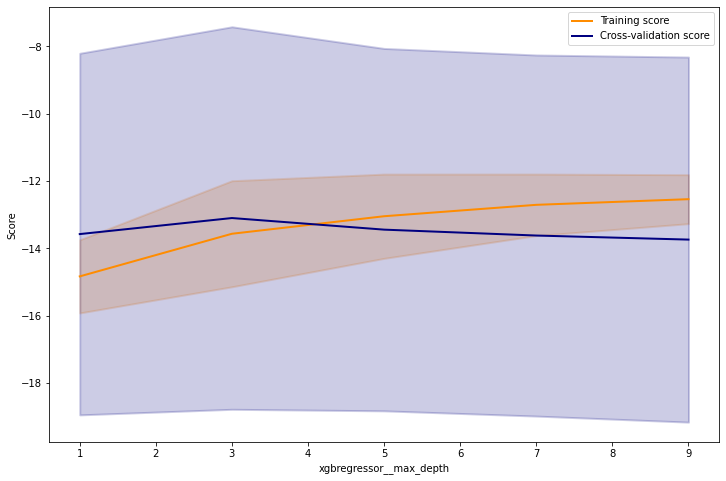

In [245]:
plot_validation_curve(xgb_max_depth_test1, max_depth_range_test1, xgb_max_depth_param)

##### More detailed

In [246]:
max_depth_range_test2 = np.arange(1, 6)

In [247]:
xgb_max_depth_test2 = validation_curve(xgb_vc_reg, X, y, param_name=xgb_max_depth_param, param_range=max_depth_range_test2, scoring=scoring, cv=cv)

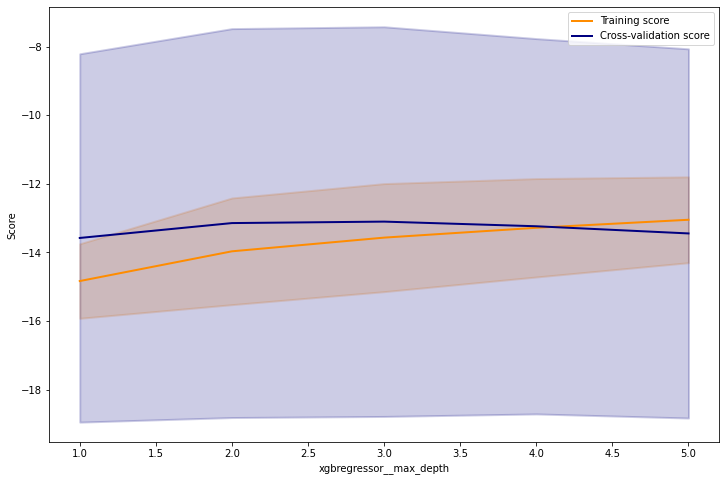

In [248]:
plot_validation_curve(xgb_max_depth_test2, max_depth_range_test2, xgb_max_depth_param)

It seems the performance is more or less similar. We will find an optimal value cross-validating.

##### Selecting best parameters

In [249]:
from sklearn.feature_selection import SelectKBest

In [250]:
xgb_kbest = make_pipeline(preprocessing, SelectKBest(score_func = mutual_info_regression), XGBRegressor())

In [251]:
preprocessing.fit_transform(X_train).shape

(28462, 31)

In [252]:
xgb_n_features_param = "selectkbest__k"
xgb_n_features_range = np.linspace(1, 30, 7).astype(int)

In [253]:
xgb_n_features_test1 = validation_curve(xgb_kbest, X, y, param_name=xgb_n_features_param, param_range=xgb_n_features_range, scoring=scoring, cv=cv, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................................selectkbest__k=1; total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END ...................................selectkbest__k=5; total time=   2.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] END ..................................selectkbest__k=10; total time=   2.7s
[CV] END ..................................selectkbest__k=15; total time=   2.8s
[CV] END ..................................selectkbest__k=20; total time=   2.8s
[CV] END ..................................selectkbest__k=25; total time=   2.9s
[CV] END ..................................selectkbest__k=30; total time=   3.2s
[CV] END ...................................selectkbest__k=1; total time=   4.3s
[CV] END ...................................selectkbest__k=5; total time=   4.4s
[CV] END ..................................selectkbest__k=10; total time=   4.6s
[CV] END ..................................selectkbest__k=15; total time=   4.6s
[CV] END ..................................selectkbest__k=20; total time=   4.3s
[CV] END ..................................selectkbest__k=25; total time=   4.6s
[CV] END ..................................selectkbest__k=30; total time=   4.9s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  9.5min finished


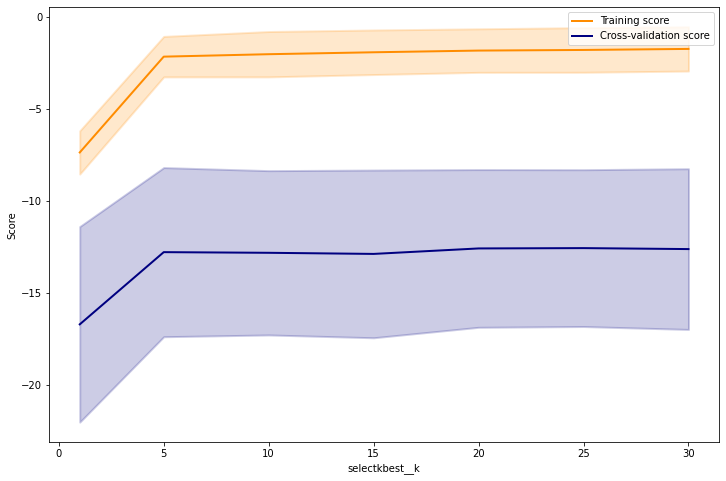

In [254]:
plot_validation_curve(xgb_n_features_test1, xgb_n_features_range, xgb_n_features_param)

### GridSearch

#### max_depth and min_child_weight

In [255]:
xgb_searchspace_test1 = {"xgbregressor__max_depth": np.arange(2, 5), 
                         "xgbregressor__min_child_weight": np.arange(1, 6, 2),
                         "xgbregressor__n_estimators": np.arange(100, 301, 40)}

In [256]:
xgb_searchspace_test1

{'xgbregressor__max_depth': array([2, 3, 4]),
 'xgbregressor__min_child_weight': array([1, 3, 5]),
 'xgbregressor__n_estimators': array([100, 140, 180, 220, 260, 300])}

In [257]:
xgb_cv_reg = make_pipeline(preprocessing, XGBRegressor())

In [258]:
xgb_cv_reg.set_params(**xgb_pretuned_params)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=112,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [259]:
xgb_cv_test1 = GridSearchCV(xgb_cv_reg, xgb_searchspace_test1, scoring=scoring, cv=cv, verbose=3)

In [260]:
xgb_cv_test1.fit(X_train, y_train)

Fitting 7 folds for each of 54 candidates, totalling 378 fits
[CV 1/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   1.8s
[CV 2/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   2.4s
[CV 3/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   3.3s
[CV 4/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   4.3s
[CV 5/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   5.5s
[CV 6/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   6.5s
[CV 7/7] END xgbregressor__max_depth=2, xgbregressor__min_child_weight=1, xgbregressor__n_estimators=100; total time=   7.6s
[CV 1/7] END xgbregressor__max_depth=2, xgbregressor__min_child

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('pipeline',
                                                         Pipeline(steps=[('energyencoder',
                                                                          EnergyEncoder()),
                                                                         ('dateencoder',
                                                                          DateEncoder(ohe_cats=False))])),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('ohe',
                                                                                          OneHotEncoder(hand...
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None,
                                                     scale_pos_weight=None,
                                                     subsample=None,
                                                     tree_method=None,
                                                     validate_parameters=None,
                                                     verbosity=None))]),
             param_grid={'xgbregressor__max_depth': array([2, 3, 4]),
                         'xgbregressor__min_child_weight': array([1, 3, 5]),
                         'xgbregressor__n_estimators': array([100, 140, 180, 220, 260, 300])},
             scoring='neg_root_mean_squared_error', verbose=3)

In [261]:
xgb_cv_test1.best_params_

{'xgbregressor__max_depth': 2,
 'xgbregressor__min_child_weight': 1,
 'xgbregressor__n_estimators': 300}

In [262]:
xgb_cv_reg.set_params(**xgb_cv_test1.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=2,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [263]:
xgb_searchspace_test2 = {"xgbregressor__n_estimators":np.arange(300, 520, 20)}

In [264]:
xgb_cv_reg_test2 = GridSearchCV(xgb_cv_reg, xgb_searchspace_test2, scoring=scoring, cv=cv, verbose=3)

In [265]:
xgb_cv_reg_test2.fit(X_train, y_train)

Fitting 7 folds for each of 11 candidates, totalling 77 fits
[CV 1/7] END .................xgbregressor__n_estimators=300; total time=   1.8s
[CV 2/7] END .................xgbregressor__n_estimators=300; total time=   2.8s
[CV 3/7] END .................xgbregressor__n_estimators=300; total time=   3.9s
[CV 4/7] END .................xgbregressor__n_estimators=300; total time=   5.3s
[CV 5/7] END .................xgbregressor__n_estimators=300; total time=   6.3s
[CV 6/7] END .................xgbregressor__n_estimators=300; total time=   7.2s
[CV 7/7] END .................xgbregressor__n_estimators=300; total time=   7.6s
[CV 1/7] END .................xgbregressor__n_estimators=320; total time=   1.9s
[CV 2/7] END .................xgbregressor__n_estimators=320; total time=   2.9s
[CV 3/7] END .................xgbregressor__n_estimators=320; total time=   3.8s
[CV 4/7] END .................xgbregressor__n_estimators=320; total time=   5.0s
[CV 5/7] END .................xgbregressor__n_es

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('pipeline',
                                                         Pipeline(steps=[('energyencoder',
                                                                          EnergyEncoder()),
                                                                         ('dateencoder',
                                                                          DateEncoder(ohe_cats=False))])),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('ohe',
                                                                                          OneHotEncoder(hand...
                                                     monotone_constraints=None,
                                                     n_estimators=300,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None,
                                                     scale_pos_weight=None,
                                                     subsample=None,
                                                     tree_method=None,
                                                     validate_parameters=None,
                                                     verbosity=None))]),
             param_grid={'xgbregressor__n_estimators': array([300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500])},
             scoring='neg_root_mean_squared_error', verbose=3)

In [266]:
xgb_cv_reg_test2.best_params_

{'xgbregressor__n_estimators': 300}

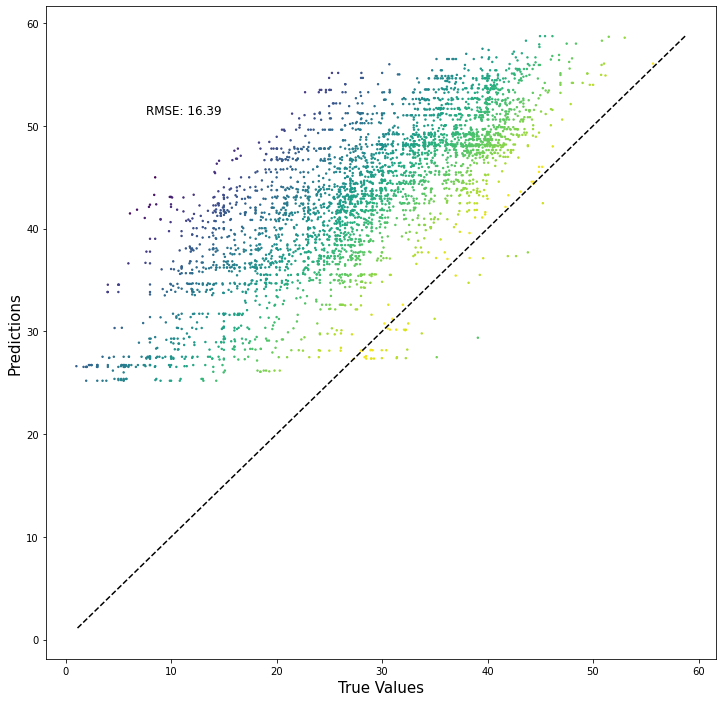

In [291]:
evaluate_model(xgb_cv_reg_test2.best_estimator_, X_test, y_test)

In [267]:
final_xgb = sklearn.base.clone(xgb_cv_reg_test2.best_estimator_)

In [306]:
final_xgb.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('energyencoder',
                                                   EnergyEncoder()),
                                                  ('dateencoder',
                                                   DateEncoder(ohe_cats=False))])),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['season',
                                                                    'day_period'])]))])),
                ('xgbregressor',
                 XGBRegressor(b...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=300, n_jobs=8, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

# Conclusion

In [268]:
columns = list(custom_preprocessing.fit_transform(X_train).columns)

one_hot_season.fit(custom_preprocessing.fit_transform(X_train))

cols_t=get_columns_from_transformer(one_hot_season, columns)

In [271]:
feat_imps = pd.DataFrame(final_xgb.named_steps["xgbregressor"].feature_importances_, index=cols_t, columns=["importance"])

feat_imps[feat_imps["importance"]>0].sort_values("importance", ascending=False)

importance
dif_fc_demand_total          0.289553
season_spring                0.107948
fc_solar_pv/fc_demand        0.098035
dif_fc_demand_fc_solar_pv    0.080524
dif_fc_demand_fc_wind        0.074482
season_autumn                0.068868
sunlight_s                   0.065301
fc_solar_pv                  0.064575
import_FR                    0.050853
total/fc_demand              0.038826
fc_nuclear                   0.032017
export_FR                    0.018286
fc_solar_th                  0.010731

## Making predictions

In [307]:
y_scoring_pred = final_xgb.predict(scoring_df)

In [308]:
y_scoring_pred = pd.DataFrame(y_scoring_pred, index=scoring_df.index, columns = ["price_pred"])

In [309]:
y_scoring_pred

price_pred
0      50.771973
1      48.736866
2      48.530499
3      48.530499
4      49.035404
...          ...
3668   32.965115
3669   34.275280
3670   33.014236
3671   30.809889
3672   30.026114

[3673 rows x 1 columns]

In [310]:
y_scoring_pred.to_csv("predictions.csv")

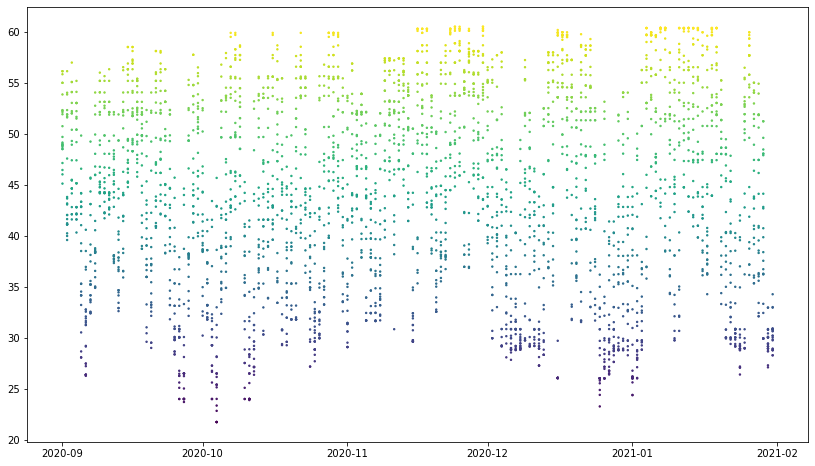

In [284]:
plt.figure(figsize=(14, 8))
plt.scatter(scoring_df["date"], y_scoring_pred, c=y_scoring_pred["price_pred"], cmap="viridis", s=2)